# Uso de Twitter en periódos electorales - Internas de la ANR, Diciembre 2017

## Recolección de tweets basada en cuentas (@) y Hashtags (#)

Usando el API de Twitter recoletamos **tweets publicados entre el 27 de Noviembre 2017 y el 15 de Enero de 2018**, que provengan de cuentas de pre-candidatos de los principales partidos políticos (ANR), y/o contengan hashtags utilizados con fines electorales. Como base utilizamos las cuentas y hashtags publicados por el Diario Última Hora en su artículo [Perfiles de pre-candidatos según las redes](http://elecciones.ultimahora.com/informacion/?id=20). Por ejemplo, Última Hora reporta que el hashtag **#JuntosPodemosMas** es utilizado para identificar tweets vínculados al candidatos Santiago Peña de Honor Colorado. Así mismo, **#MaritoDeLaGente** se utilzan en tweets publicados en favor del candidato del movimiento Colorado Añeteté.

[Aquí](https://docs.google.com/spreadsheets/d/e/2PACX-1vQHoukfR9AFhSaz30QHYwKqpwexe1ASrW8ya25Fueh3jXcRPMSjrAyj4SbzryTLiuKkPdi6fsprqtM2/pubhtml) se puede acceder a lista completa de hashtags y cuentas.

## Tamaño del data set

In [1]:
%matplotlib inline

import os
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

os.chdir('../..')

from src.utils.db_manager import *
from src.utils.data_wrangler import *
from src.analyzer.data_analyzer import *
from src.analyzer.network_analysis import NetworkAnalyzer

plt.style.use('seaborn')

In [2]:
db = DBManager('tweets')
total_tweets = db.search({'flag.partido_politico.anr': {'$gt': 0}}, only_relevant_tws=False).count()
print('Se recolectaron {0} tweets relacionados a la interna de la ANR'.format(total_tweets))

Se recolectaron 178860 tweets relacionados a la interna de la ANR


## Selección de tweets relevantes

Encontramos que los hashtags usados por los candidatos en sus campañas era también utilizados en otros contextos (en otros paises) por lo tanto para el estudio consideramos solo aquellos tweets que además de los hashtags de interés contienen alguna mención a cuentas de los candidatos.

In [33]:
#te = TweetEvaluator()
#te.identify_relevant_tweets()
relevant_tweets = db.search({'flag.partido_politico.anr': {'$gt': 0}}).count()
per_relevant = round(100*(relevant_tweets/total_tweets),0)
print('Del total de {0} tweets con hashtags relacionados a la campaña de la ANR, seleccionamos {1} que encontramos ' \
      'relevantes para el trabajo ({2}% del total)'.
      format(total_tweets, relevant_tweets, per_relevant))

Del total de 178860 tweets con hashtags relacionados a la campaña de la ANR, seleccionamos 145021 que encontramos relevantes para el trabajo (81.0% del total)


## Número de perfiles autores de tweets

In [3]:
dbu = DBManager('users')
#unique_tw_authors = db.get_unique_users(**{'partido':'anr'})
unique_tw_authors = dbu.search({'party': 'anr'})

In [5]:
print('En total {0} perfiles publicaron tweets, retweets, replies, y citaciones relacionadas a las internas del partido colorado'.format(unique_tw_authors.count()))

En total 23245 perfiles publicaron tweets, retweets, replies, y citaciones relacionadas a las internas del partido colorado


## Tipos de tweets

In [6]:
original_tweets = db.get_original_tweets(**{'partido': 'anr'})
num_original_tweets = len(original_tweets)
retweets = db.get_retweets(**{'partido': 'anr'})
num_retweets = len(retweets)
replies = db.get_replies(**{'partido': 'anr'})
num_replies = len(replies)
quotes = db.get_quotes(**{'partido': 'anr'})
num_quotes = len(quotes)
tweets_por_tipo = pd.DataFrame({
    'Tipo': ['Original', 'Retweet', 'Reply', 'Quote'],
    'Tweets': [num_original_tweets, num_retweets, num_replies, num_quotes]
}, index=['ot', 'rt', 'rp', 'qt'])

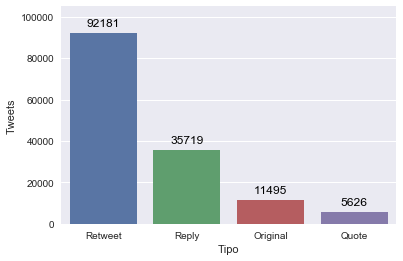

In [7]:
fig = sns.barplot(x='Tipo', y='Tweets', data=tweets_por_tipo, order=['Retweet', 'Reply', 'Original', 'Quote'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,105000) #To make space for the annotations
plt.show()

### Honor Colorado

#### Tweets Originales

In [26]:
original_tweets_hc = db.search({'flag.partido_politico.anr': {'$gt': 0},
                                'flag.movimiento.honor colorado': {'$gt': 0}, 
                                'flag.movimiento.colorado añetete': {'$eq': 0},
                                'relevante': 1,
                                'tweet_obj.retweeted_status': {'$exists': 0},
                                'tweet_obj.in_reply_to_status_id_str': {'$eq': None},
                                'tweet_obj.is_quote_status': False})
num_original_tweets_hc = original_tweets_hc.count()

#### Retweets

In [28]:
retweets_hc = db.search({'flag.partido_politico.anr': {'$gt': 0},
                         'flag.movimiento.honor colorado': {'$gt': 0}, 
                         'flag.movimiento.colorado añetete': {'$eq': 0},
                         'relevante': 1,
                         'tweet_obj.retweeted_status': {'$exists': 1},
                         'tweet_obj.in_reply_to_status_id_str': {'$eq': None},
                         'tweet_obj.is_quote_status': False})
num_retweets_hc = retweets_hc.count()

#### Replies

In [29]:
replies_hc = db.search({'flag.partido_politico.anr': {'$gt': 0},
                        'flag.movimiento.honor colorado': {'$gt': 0}, 
                        'flag.movimiento.colorado añetete': {'$eq': 0},
                        'relevante': 1,
                        'tweet_obj.retweeted_status': {'$exists': 0},
                        'tweet_obj.in_reply_to_status_id_str': {'$ne': None},
                        'tweet_obj.is_quote_status': False})
num_replies_hc = replies_hc.count()

#### Quotes

In [30]:
quotes_hc = db.search({'flag.partido_politico.anr': {'$gt': 0},
                       'flag.movimiento.honor colorado': {'$gt': 0}, 
                       'flag.movimiento.colorado añetete': {'$eq': 0},
                       'relevante': 1,
                       'tweet_obj.is_quote_status': True})
num_quotes_hc = quotes_hc.count()

#### Gráfico

In [12]:
tweets_por_tipo_hc = pd.DataFrame({
    'Tipo': ['Original', 'Retweet', 'Reply', 'Quote'],
    'Tweets': [num_original_tweets_hc, num_retweets_hc, num_replies_hc, num_quotes_hc]
}, index=['ot', 'rt', 'rp', 'qt'])

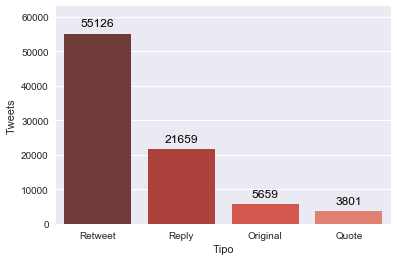

In [13]:
fig = sns.barplot(x='Tipo', y='Tweets', data=tweets_por_tipo_hc, order=['Retweet', 'Reply', 'Original', 'Quote'],
                 palette="Reds_d")
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,63000) #To make space for the annotations
plt.show()

### Colorado Añeteté

#### Tweets Originales

In [34]:
original_tweets_ca = db.search({'flag.partido_politico.anr': {'$gt': 0},
                                'flag.movimiento.honor colorado': {'$eq': 0}, 
                                'flag.movimiento.colorado añetete': {'$gt': 0},
                                'relevante': 1,
                                'tweet_obj.retweeted_status': {'$exists': 0},
                                'tweet_obj.in_reply_to_status_id_str': {'$eq': None},
                                'tweet_obj.is_quote_status': False})
num_original_tweets_ca = original_tweets_ca.count()

#### Retweets

In [35]:
retweets_ca = db.search({'flag.partido_politico.anr': {'$gt': 0},
                         'flag.movimiento.honor colorado': {'$eq': 0}, 
                         'flag.movimiento.colorado añetete': {'$gt': 0},
                         'relevante': 1,
                         'tweet_obj.retweeted_status': {'$exists': 1},
                         'tweet_obj.in_reply_to_status_id_str': {'$eq': None},
                         'tweet_obj.is_quote_status': False})
num_retweets_ca = retweets_ca.count()

#### Replies

In [36]:
replies_ca = db.search({'flag.partido_politico.anr': {'$gt': 0},
                        'flag.movimiento.honor colorado': {'$eq': 0}, 
                        'flag.movimiento.colorado añetete': {'$gt': 0},
                        'relevante': 1,
                        'tweet_obj.retweeted_status': {'$exists': 0},
                        'tweet_obj.in_reply_to_status_id_str': {'$ne': None},
                        'tweet_obj.is_quote_status': False})
num_replies_ca = replies_ca.count()

#### Quotes

In [37]:
quotes_ca = db.search({'flag.partido_politico.anr': {'$gt': 0},
                       'flag.movimiento.honor colorado': {'$eq': 0}, 
                       'flag.movimiento.colorado añetete': {'$gt': 0},
                       'relevante': 1,
                       'tweet_obj.is_quote_status': True})
num_quotes_ca = quotes_ca.count()

#### Gráfico

In [19]:
tweets_por_tipo_ca = pd.DataFrame({
    'Tipo': ['Original', 'Retweet', 'Reply', 'Quote'],
    'Tweets': [num_original_tweets_ca, num_retweets_ca, num_replies_ca, num_quotes_ca]
}, index=['ot', 'rt', 'rp', 'qt'])

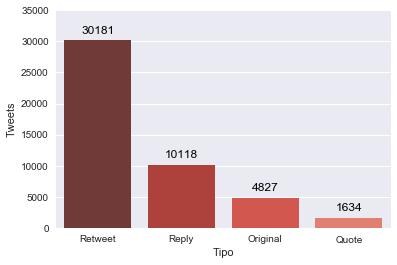

In [20]:
fig = sns.barplot(x='Tipo', y='Tweets', data=tweets_por_tipo_ca, order=['Retweet', 'Reply', 'Original', 'Quote'],
                 palette="Reds_d")
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,35000) #To make space for the annotations
plt.show()

Los conjuntos de tweets de **`Honor Colorado`** y **`Colorado Añeteté`** no son mutuamente excluyentes ya que existen tweets que contienen menciones a los candidatos de ambos movimientos o que tienen hashtags relacionados a los dos movimientos. Por ejemplo el siguiente tweet

In [21]:
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

In [22]:
s = ("""
<blockquote class="twitter-tweet" data-lang="en"><p lang="es" dir="ltr">.<a href="https://twitter.com/SantiPenap?ref_src=twsrc%5Etfw">@SantiPenap</a>: &quot;Me parece indignante que <a href="https://twitter.com/MaritoAbdo?ref_src=twsrc%5Etfw">@MaritoAbdo</a> siga recibiendo un salario del Estado y haciendo campaña. Si está seguro que va a ganar, le desafío a que mañana renuncie a su banca en <a href="https://twitter.com/SenadoresPy?ref_src=twsrc%5Etfw">@SenadoresPy</a>&quot; <a href="https://twitter.com/hashtag/COCPY?src=hash&amp;ref_src=twsrc%5Etfw">#COCPY</a></p>&mdash; Jorge Torres Romero (@jtorresromero) <a href="https://twitter.com/jtorresromero/status/937488208492941312?ref_src=twsrc%5Etfw">December 4, 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(s)

## Evolución de tweets en el tiempo

### General

In [11]:
tw_by_date = db.get_tweets_by_date(**{'partido': 'anr'})
tweets_por_fecha = pd.DataFrame(tw_by_date)
tweets_por_fecha.head()

,_id,count,date,partido
0,11/24/17,89,2017-11-24,anr
1,11/25/17,283,2017-11-25,anr
2,11/26/17,334,2017-11-26,anr
3,11/27/17,489,2017-11-27,anr
4,11/28/17,527,2017-11-28,anr


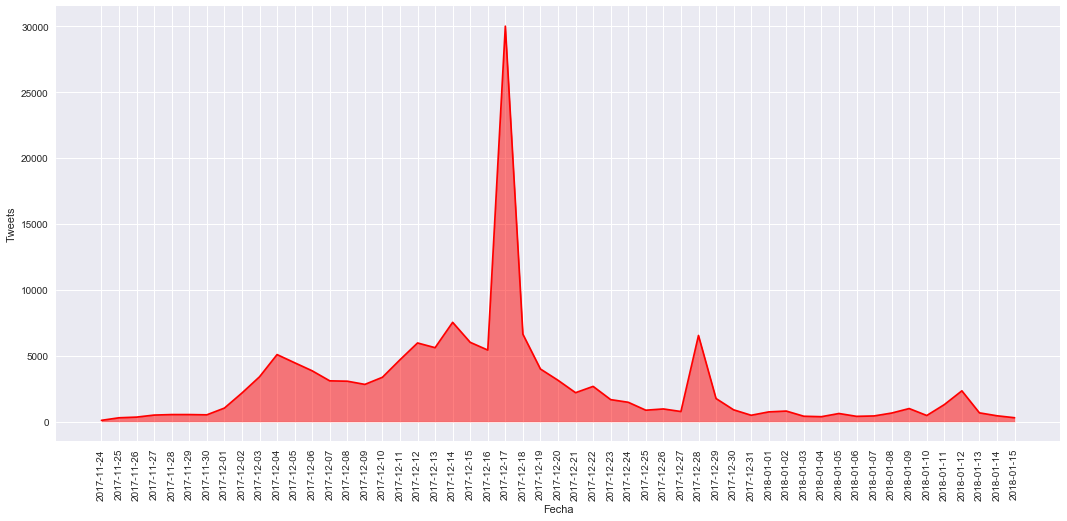

In [12]:
plt.figure(figsize=(18,8))
# get list of indexes
l_index = list(tweets_por_fecha.index)
# convert timestamps to string
l_dates = []
for i in range(tweets_por_fecha.shape[0]):
    l_dates.append(str(tweets_por_fecha.iloc[i, 2]).split()[0])
fig = sns.lineplot(x=l_dates, y=tweets_por_fecha['count'], color="red")
fig.set(xlabel='Fecha', ylabel='Tweets')
sns.set_style("dark", {'axes.grid': True})
fig.set_xticklabels(labels=l_dates, rotation=90)
plt.fill_between(l_index, tweets_por_fecha['count'], alpha=0.5, color='red')
plt.show()
fig.get_figure().savefig("tweets_over_time.png", dpi=200, quality=95, bbox_inches="tight")

### Por movimiento

In [26]:
# get tweets by date
tw_by_date_hc = db.get_tweets_by_date(**{'partido':'anr', 'movimiento': 'honor colorado', 
                                         'no_movimiento': 'colorado añetete'})
tw_by_date_ca = db.get_tweets_by_date(**{'partido':'anr', 'movimiento': 'colorado añetete',
                                         'no_movimiento': 'honor colorado'})
# convert list to pandas' dataframe
tweets_por_fecha = pd.DataFrame(tw_by_date_hc)
tweets_por_fecha = tweets_por_fecha.append(pd.DataFrame(tw_by_date_ca))

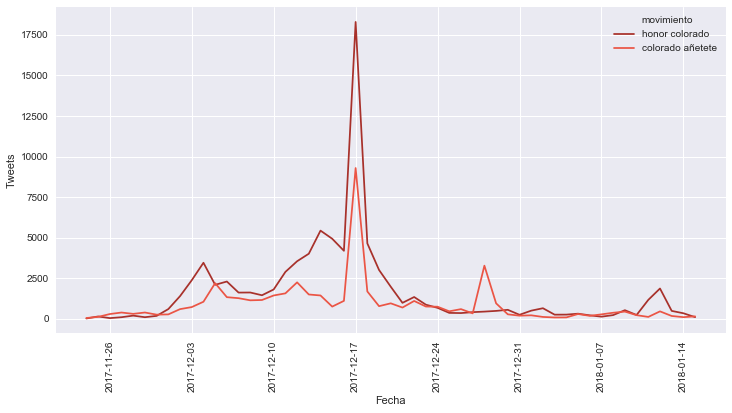

In [27]:
# draw and show the figure
# set figure size
plt.figure(figsize=(12,6))
fig = sns.lineplot(x='date', y='count', data=tweets_por_fecha, hue="movimiento", 
                    palette="Reds_d")
fig.set(xlabel='Fecha', ylabel='Tweets')
for item in fig.get_xticklabels():
    item.set_rotation(90)
plt.show()
fig.get_figure().savefig("tweets_over_time_movimientos.png", dpi=200, quality=95)

La publicación de tweets fue creciendo con el paso del tiempo. El día de las elecciones (**`17 de diciembre`**) se concentró el mayor de publicaciones de tweets, más de **`30.000`** tweets (honor colorado 20.478, colorado añeteté 11.474) se publicaron ese día. Pasadas las elecciones los tweets relacionados a las internas decrecieron significativamente con un pequeño pico el día de 28 de diciembre. Esto pudo haberse debido a que ese día el presidente de la república y líder del Movimiento Honor Colorado, Horacio Cartes, confirmó su reunión con Mario Abdo Benítez, líder de Colorado Añeteté, en busca de la unidad del Partido Colorado ([Cartes confirma abrazo republicano](http://www.abc.com.py/nacionales/cartes-confirma-abrazo-republicano-1662344.html)).

## Cantidad de Tweets por movimiento

Exploraremos la distribución de tweets considerando los dos movimiento más importantes en estas internas, es decir **`Honor Colorado`** y **`Colorado Añeteté`**.

### Honor Colorado

In [38]:
tweets_hc = db.search({'flag.partido_politico.anr': {'$gt': 0},
                       'flag.movimiento.honor colorado': {'$gt': 0}, 
                       'flag.movimiento.colorado añetete': {'$eq': 0},
                       'relevante': 1})
print('Se publicaron {0} tweets relacionados al movimiento Honor Colorado ({1}% del total)'.
      format(tweets_hc.count(), round((tweets_hc.count()/relevant_tweets)*100,2)))

Se publicaron 86245 tweets relacionados al movimiento Honor Colorado (59.47% del total)


### Colorado Añeteté

In [39]:
tweets_ca = db.search({'flag.partido_politico.anr': {'$gt': 0},
                       'flag.movimiento.colorado añetete': {'$gt': 0},
                       'flag.movimiento.honor colorado': {'$eq': 0},
                       'relevante': 1})
print('Se publicaron {0} tweets relacionados al movimiento Colorado Añetete ({1}% del total)'.
      format(tweets_ca.count(), round((tweets_ca.count()/relevant_tweets)*100,2)))

Se publicaron 46760 tweets relacionados al movimiento Colorado Añetete (32.24% del total)


### Ambos

In [18]:
tweets_hc_ca = db.search({'flag.partido_politico.anr': {'$gt': 0},
                          'flag.movimiento.colorado añetete': {'$gt': 0},
                          'flag.movimiento.honor colorado': {'$gt': 0},
                          'relevante': 1})
print('Se publicaron {0} tweets relacionados a ambos movimientos ({1}% del total)'.
      format(tweets_hc_ca.count(), round((tweets_hc_ca.count()/relevant_tweets)*100,2)))

Se publicaron 10917 tweets relacionados a ambos movimientos (7.53% del total)


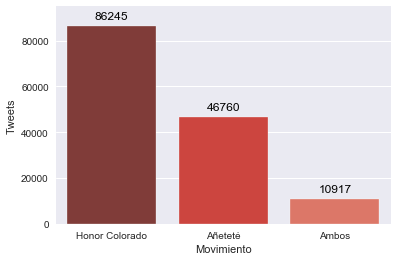

In [32]:
tweets_por_movimiento = pd.DataFrame({
    'Movimiento': ['Honor Colorado', 'Añeteté', 'Ambos'],
    'Tweets': [tweets_hc.count(), tweets_ca.count(), tweets_hc_ca.count()]
}, index=['hc', 'ca', 'ambos'])
fig = sns.barplot(x='Movimiento', y='Tweets', data=tweets_por_movimiento, palette="Reds_d")
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,95000) #To make space for the annotations
plt.show()

Los tweets relacionados al movimiento **`Honor Colorado`** constituyen casi el **`60%`** de nuestro data set mientras que los vinculados a las candidaturas del movimiento **`Colorado Añeteté`** representan menos del **`35%`** del total de datos. El restante porcentaje se distribuye entre tweet que hacen referencia a ambos movimiento (7%) y tweets vínculados a las internas de la ANR pero no necesariamente a alguno de estos dos movimiento, por ejemplo, tweets que utilizan solamente el hashtag **`#InternasANR`**.

## Cantidad de Tweets por Movimiento por día

### Honor Colorado

In [33]:
mean_tweets_hc = tweets_por_fecha[tweets_por_fecha['movimiento']=='honor colorado']['count'].mean()
print('Honor Colorado publicó en promedio {0} tweets por día'.format(int(mean_tweets_hc)))

Honor Colorado publicó en promedio 1627 tweets por día


### Colorado Añeteté

In [34]:
mean_tweets_ca = tweets_por_fecha[tweets_por_fecha['movimiento']=='colorado añetete']['count'].mean()
print('Colorado Añeteté publicó en promedio {0} tweets por día'.format(int(mean_tweets_ca)))

Colorado Añeteté publicó en promedio 882 tweets por día


## Frecuencia de posteo

In [35]:
fp = db.get_posting_frequency_in_seconds(**{'partido': 'anr'})
fp_df = pd.DataFrame(fp)

In [36]:
print('En promedio se publicaron tweets relacionados a la internas del Partido Colorado cada {0} segundos'.
      format(round(fp_df['diff_with_previous'].mean(), 2)))

En promedio se publicaron tweets relacionados a la internas del Partido Colorado cada 31.07 segundos


### Honor Colorado

In [4]:
fp_hc = db.get_posting_frequency_in_seconds(**{'partido': 'anr', 'movimiento': 'honor colorado',
                                               'no_movimiento': 'colorado añetete'})
fp_hc_df = pd.DataFrame(fp_hc)

In [5]:
print('En promedio se publicaron tweets relacionados al movimiento Honor Colorado cada {0} segundos'.
      format(round(fp_hc_df['diff_with_previous'].mean(), 2)))

En promedio se publicaron tweets relacionados al movimiento Honor Colorado cada 52.13 segundos


### Colorado Añeteté

In [7]:
fp_ca = db.get_posting_frequency_in_seconds(**{'partido': 'anr', 'movimiento': 'colorado añetete',
                                               'no_movimiento': 'honor colorado'})
fp_ca_df = pd.DataFrame(fp_ca)

In [8]:
print('En promedio se publicaron tweets relacionados al movimiento Colorado Añeteté cada {0} segundos'.
      format(round(fp_ca_df['diff_with_previous'].mean(), 2)))

En promedio se publicaron tweets relacionados al movimiento Colorado Añeteté cada 96.32 segundos


## Distribución de tweets por hora el día D (17/12/17)

In [9]:
# get tweets by hour by movement
hc_tw_by_hour = db.get_tweets_by_hour('12/17/17', **{'partido': 'anr','movimiento': 'honor colorado',
                                                     'no_movimiento': 'colorado añetete'})
ca_tw_by_hour = db.get_tweets_by_hour('12/17/17', **{'partido': 'anr','movimiento': 'colorado añetete',
                                                     'no_movimiento': 'honor colorado'})
# convert list to pandas' dataframe
tweets_by_hour = pd.DataFrame(hc_tw_by_hour)
tweets_by_hour = tweets_by_hour.append(pd.DataFrame(ca_tw_by_hour))

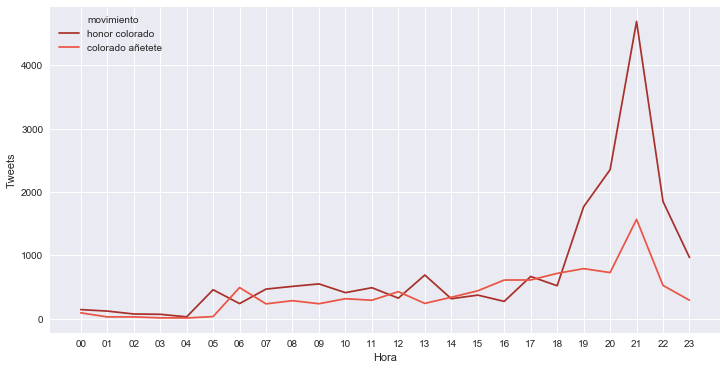

In [10]:
# set figure size
plt.figure(figsize=(12,6))
# draw and show the figure
fig = sns.lineplot(x='hour', y='count', data=tweets_by_hour, hue="movimiento", 
                    palette="Reds_d")
fig.set(xlabel='Hora', ylabel='Tweets')
#for item in fig.get_xticklabels():
#    item.set_rotation(90)
plt.show()
fig.get_figure().savefig("tweets_dia_d_por_movimiento.png", dpi=200, quality=95, bbox_inches="tight")

La cantidad de tweets con información relacionada a **`Honor Colorado`** fue superior durante toda la jornada electoral con respecto a los tweets de **`Colorado Añeteté`**, inclusive aún después de la proclamación del TREP (20 hs)

### ¿Qué pasó entre las 20 y las 21 hs?

In [14]:
tweets = db.search({'tweet_py_date': '12/17/17', 
                    '$or': [{'tweet_py_hour': '21'}, {'tweet_py_hour': '20'}], 
                    'flag.partido_politico.anr': {'$gt': 0},
                    'flag.movimiento.honor colorado': {'$gt': 0}, 
                    'flag.movimiento.colorado añetete': {'$eq': 0}})
org_tweets, rts, rps, qts = [], [], [], []
tweets_rt = defaultdict(int)
for tweet in tweets:
    if 'retweeted_status' in tweet['tweet_obj'].keys() and \
        not tweet['tweet_obj']['in_reply_to_status_id_str'] and \
        not tweet['tweet_obj']['is_quote_status']:
        rts.append({'id_str': tweet['tweet_obj']['id_str'], 
                    'author': tweet['tweet_obj']['user']['screen_name']})
        key = 'https://www.twitter.com/' + tweet['tweet_obj']['retweeted_status']['user']['screen_name'] + \
              '/status/' + tweet['tweet_obj']['retweeted_status']['id_str']
        tweets_rt[key] += 1
    elif 'retweeted_status' not in tweet['tweet_obj'].keys() and \
         tweet['tweet_obj']['in_reply_to_status_id_str'] and \
         not tweet['tweet_obj']['is_quote_status']:
        rps.append({'id_str': tweet['tweet_obj']['id_str'], 'author': tweet['tweet_obj']['user']['screen_name']})
    elif tweet['tweet_obj']['is_quote_status']:
        qts.append({'id_str': tweet['tweet_obj']['id_str'], 'author': tweet['tweet_obj']['user']['screen_name']})
    else:
        org_tweets.append({'id_str': tweet['tweet_obj']['id_str'], 'author': tweet['tweet_obj']['user']['screen_name']})
print('Tweet originales: {0}'.format(len(org_tweets)))
print('RT: {0}'.format(len(rts)))
print('RP: {0}'.format(len(rps)))
print('QT: {0}'.format(len(qts)))

Tweet originales: 501
RT: 5207
RP: 1075
QT: 258


In [15]:
s_rt_tweets = [k for k in sorted(tweets_rt.items(), key=lambda k_v: k_v[1], reverse=True)]

In [16]:
s_rt_tweets[0]

('https://www.twitter.com/LuisBareiro/status/942544597410045953', 1434)

## Distribución de tweets por candidato

Para esta parte del análisis solo se tuvieron en cuenta los tweets que contienen hashtags utilizados exclusivamente para promocionar las **candidaturas** presidenciales, no los **movimientos** o **partidos**. Por ejemplo, los hashtags **`#JuntosPodemosMas`** o **`#CaminandoJuntos`** son hashtags vinculados principalmente a la figura de Santiago Peña no así el hashtag **`#HonorColorado`** que se utiliza para referirse al movimiento partidario pero no necesariamente la candidatura de Peña. De igual manera, los hashtags **`#MaritoDeLaGente`** o **`ParaguayDeLaGente`** fueron usados para promocionar la campaña de Mario Abdo, no necesariamente las candidatura del movimiento Colorado Añeteté al que pertenece.

Los tweets publicados por las cuentas personales de los candidatos no son tenidos en cuenta en este análisis.

### Santiago Peña

Hashtags de ejemplo: **`#JuntosPodemosMas`**, **`#CaminandoJuntos`**, **`#SantiPresidente`**, **`#VotoxSanti`**, **`#SigamosConversando`**

In [19]:
tweets_sp = db.search({'flag.partido_politico.anr': {'$gt': 0},
                       'flag.candidatura.santiago peña': {'$gt': 0},
                       'flag.candidatura.mario abdo': {'$eq': 0},
                       'flag.movimiento.colorado añetete': {'$eq': 0},
                       'tweet_obj.user.screen_name': {'$ne': 'SantiPenap'},
                       'relevante': {'$eq': 1}})
per_tweet_sp = round((tweets_sp.count()/tweets_hc.count())*100,2)
print('Se publicaron {0} tweets que utilizaron hashtags vinculados a la candidatura de Santiago Peña ' \
      '({1}% del total de los tweets de Honor Colorado)'.
      format(tweets_sp.count(), per_tweet_sp))

Se publicaron 58282 tweets que utilizaron hashtags vinculados a la candidatura de Santiago Peña (67.58% del total de los tweets de Honor Colorado)


### Mario Abdo Benítez

Hashtags de ejemplo: **`#MaritoDeLaGente`**, **`#ParaguayDeLaGente`**, **`#MaritoImparable`**, **`#MaritoPresidente`**, **`#1000KmConLaGente`**

In [20]:
tweets_ma = db.search({'flag.partido_politico.anr': {'$gt': 0},
                       'flag.candidatura.santiago peña': {'$eq': 0},
                       'flag.candidatura.mario abdo': {'$gt': 0},
                       'flag.movimiento.honor colorado': {'$eq': 0},
                       'tweet_obj.user.screen_name': {'$ne': 'maritoabdo'},
                       'relevante': {'$eq': 1}})
per_tweet_ma = round((tweets_ma.count()/tweets_ca.count())*100,2)
print('Se publicaron {0} tweets que utilizaron hashtags vinculados a la candidatura de Mario Abdo ' \
      '({1}% del total de los tweets de Colorado Añeteté)'.
      format(tweets_ma.count(), per_tweet_ma))

Se publicaron 46275 tweets que utilizaron hashtags vinculados a la candidatura de Mario Abdo (98.96% del total de los tweets de Colorado Añeteté)


### Tweets sobre candidatos sobre el total de su movimiento

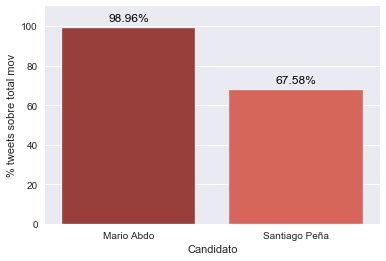

In [21]:
tweets_por_candidato_anr = pd.DataFrame({
    'Candidato': ['Santiago Peña', 'Mario Abdo'],
    '% tweets sobre total mov': [per_tweet_sp,per_tweet_ma]
}, index=['sp', 'ma'])
fig = sns.barplot(x='Candidato', y='% tweets sobre total mov', data=tweets_por_candidato_anr, 
                  order=['Mario Abdo', 'Santiago Peña'], palette="Reds_d")
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("{0}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,110) #To make space for the annotations
plt.show()

### Sin tweets negativos

In [22]:
# Tweets HC no negativos
tweets_hc_nn = db.search({'flag.partido_politico.anr': {'$gt': 0},
                          'flag.movimiento.honor colorado': {'$gt': 0}, 
                          'flag.movimiento.colorado añetete': {'$eq': 0},
                          'relevante': 1,
                          'sentimiento.tono': {'$ne': 'negative'}})
tweets_hc_nn.count()

70148

In [23]:
# Tweets Santi Peña no negativos
tweets_sp_nn = db.search({'flag.partido_politico.anr': {'$gt': 0},
                          'flag.candidatura.santiago peña': {'$gt': 0},
                          'flag.candidatura.mario abdo': {'$eq': 0},
                          'flag.movimiento.colorado añetete': {'$eq': 0},
                          'tweet_obj.user.screen_name': {'$ne': 'SantiPenap'},
                          'sentimiento.tono': {'$ne': 'negative'},
                          'relevante': 1})
per_tweet_sp_nn = round((tweets_sp_nn.count()/tweets_hc_nn.count())*100,2)
per_tweet_sp_nn

68.31

In [24]:
# Tweets Colorado Añeteté no negativos
tweets_ca_nn = db.search({'flag.partido_politico.anr': {'$gt': 0},
                          'flag.movimiento.honor colorado': {'$eq': 0}, 
                          'flag.movimiento.colorado añetete': {'$gt': 0},
                          'relevante': 1,
                          'sentimiento.tono': {'$ne': 'negative'}})
tweets_ca_nn.count()

40688

In [25]:
# Tweets Mario Abdo no negativos
tweets_ma_nn = db.search({'flag.partido_politico.anr': {'$gt': 0},
                          'flag.candidatura.santiago peña': {'$eq': 0},
                          'flag.candidatura.mario abdo': {'$gt': 0},
                          'flag.movimiento.honor colorado': {'$eq': 0},
                          'tweet_obj.user.screen_name': {'$ne': 'maritoabdo'},
                          'sentimiento.tono': {'$ne': 'negative'},
                          'relevante': 1})
per_tweet_ma_nn = round((tweets_ma_nn.count()/tweets_ca_nn.count())*100,2)
per_tweet_ma_nn

98.88

## Tonalidad de Tweets

En este análisis se consideran solo tweets originales, replies, y quotes. Los retweets son descartados.

In [26]:
st = db.get_sentiment_tweets(**{'partido': 'anr'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df = pd.DataFrame(st_dict)

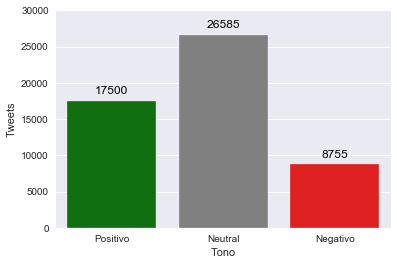

In [27]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,30000) #To make space for the annotations
plt.show()

### Honor Colorado

In [28]:
st = db.get_sentiment_tweets(**{'partido': 'anr', 'movimiento': 'honor colorado', 
                                'no_movimiento': 'colorado añetete'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_hc = pd.DataFrame(st_dict)

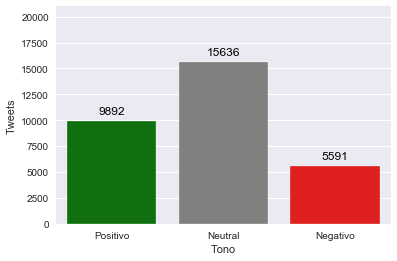

In [29]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_hc, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,21000) #To make space for the annotations
plt.show()

In [30]:
total = sum(st_df_hc['Tweets'])
positive = int(st_df_hc[st_df_hc['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_hc[st_df_hc['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_hc[st_df_hc['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 31.8%
Tweets Negativos: 18.0%
Tweets Neutrales: 50.2%


#### Tweets Originales

In [31]:
st = db.get_sentiment_tweets(type_query='original', **{'partido': 'anr', 'movimiento': 'honor colorado',
                                                       'no_movimiento': 'colorado añetete'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_hc = pd.DataFrame(st_dict)

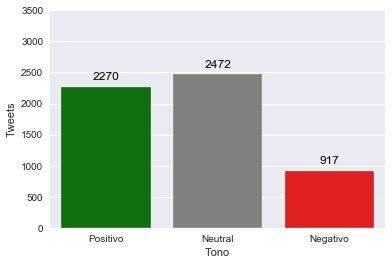

In [32]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_hc, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,3500) #To make space for the annotations
plt.show()

In [33]:
total = sum(st_df_hc['Tweets'])
positive = int(st_df_hc[st_df_hc['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_hc[st_df_hc['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_hc[st_df_hc['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 40.1%
Tweets Negativos: 16.2%
Tweets Neutrales: 43.7%


#### Replies

In [34]:
st = db.get_sentiment_tweets(type_query='replies', **{'partido': 'anr', 'movimiento': 'honor colorado',
                                                      'no_movimiento': 'colorado añetete'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_hc = pd.DataFrame(st_dict)

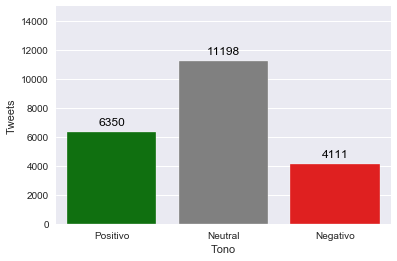

In [35]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_hc, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,15000) #To make space for the annotations
plt.show()

In [36]:
total = sum(st_df_hc['Tweets'])
positive = int(st_df_hc[st_df_hc['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_hc[st_df_hc['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_hc[st_df_hc['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 29.3%
Tweets Negativos: 19.0%
Tweets Neutrales: 51.7%


#### Quotes

In [37]:
st = db.get_sentiment_tweets(type_query='quotes', **{'partido': 'anr', 'movimiento': 'honor colorado',
                                                     'no_movimiento': 'colorado añetete'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_hc = pd.DataFrame(st_dict)

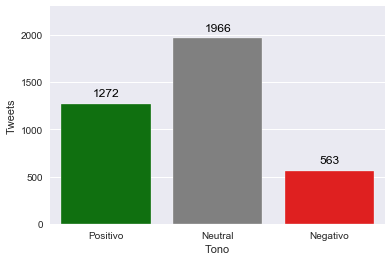

In [38]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_hc, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,2300) #To make space for the annotations
plt.show()

In [23]:
total = sum(st_df_hc['Tweets'])
positive = int(st_df_hc[st_df_hc['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_hc[st_df_hc['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_hc[st_df_hc['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 33.7%
Tweets Negativos: 15.0%
Tweets Neutrales: 51.3%


### Colorado Añeteté

In [39]:
st = db.get_sentiment_tweets(**{'partido': 'anr', 'movimiento': 'colorado añetete', 
                                'no_movimiento': 'honor colorado'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_ca = pd.DataFrame(st_dict)

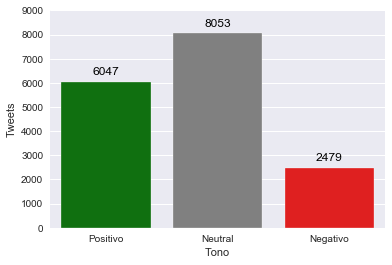

In [41]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_ca, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,9000) #To make space for the annotations
plt.show()

In [42]:
total = sum(st_df_ca['Tweets'])
positive = int(st_df_ca[st_df_ca['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_ca[st_df_ca['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_ca[st_df_ca['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 36.5%
Tweets Negativos: 15.0%
Tweets Neutrales: 48.6%


#### Tweets Originales

In [43]:
st = db.get_sentiment_tweets(type_query = 'original', **{'partido': 'anr', 'movimiento': 'colorado añetete',
                                                         'no_movimiento': 'honor colorado'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_ca = pd.DataFrame(st_dict)

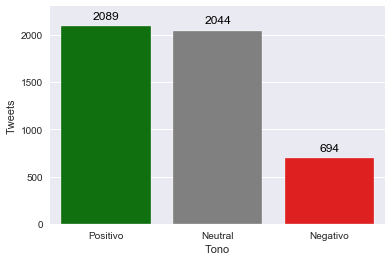

In [48]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_ca, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,2300) #To make space for the annotations
plt.show()

In [49]:
total = sum(st_df_ca['Tweets'])
positive = int(st_df_ca[st_df_ca['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_ca[st_df_ca['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_ca[st_df_ca['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 43.3%
Tweets Negativos: 14.4%
Tweets Neutrales: 42.3%


#### Replies

In [50]:
st = db.get_sentiment_tweets(type_query = 'replies', **{'partido': 'anr', 'movimiento': 'colorado añetete',
                                                        'no_movimiento': 'honor colorado'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_ca = pd.DataFrame(st_dict)

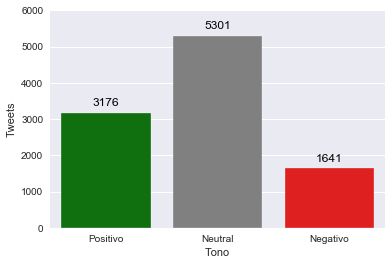

In [52]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_ca, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,6000) #To make space for the annotations
plt.show()

In [53]:
total = sum(st_df_ca['Tweets'])
positive = int(st_df_ca[st_df_ca['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_ca[st_df_ca['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_ca[st_df_ca['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 31.4%
Tweets Negativos: 16.2%
Tweets Neutrales: 52.4%


#### Quotes

In [57]:
st = db.get_sentiment_tweets(type_query = 'quotes', **{'partido': 'anr', 'movimiento': 'colorado añetete',
                                                       'no_movimiento': 'honor colorado'})
st_dict = {
    'Tono': [],
    'Tweets': []
}
for sen in st:
    if sen['sentiment'] == 'positive':
        st_dict['Tono'].append('Positivo')
    elif sen['sentiment'] == 'negative':
        st_dict['Tono'].append('Negativo')
    else:
        st_dict['Tono'].append('Neutral')
    st_dict['Tweets'].append(sen['count'])
st_df_ca = pd.DataFrame(st_dict)

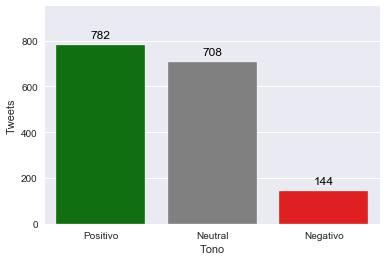

In [58]:
fig = sns.barplot(x='Tono', y='Tweets', data=st_df_ca, 
                  order=['Positivo', 'Neutral', 'Negativo'],
                  palette=['green','gray', 'red'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,950) #To make space for the annotations
plt.show()

In [59]:
total = sum(st_df_ca['Tweets'])
positive = int(st_df_ca[st_df_ca['Tono'] == 'Positivo']['Tweets'])
negative = int(st_df_ca[st_df_ca['Tono'] == 'Negativo']['Tweets'])
neutral = int(st_df_ca[st_df_ca['Tono'] == 'Neutral']['Tweets'])
print('Tweets Positivos: {0}%'.format(round(100*positive/total, 1)))
print('Tweets Negativos: {0}%'.format(round(100*negative/total, 1)))
print('Tweets Neutrales: {0}%'.format(round(100*neutral/total, 1)))

Tweets Positivos: 47.9%
Tweets Negativos: 8.8%
Tweets Neutrales: 43.3%


La distribución de tweets por tonalidad es bastante similar en ambos movimientos. Los resultados se mantienen aún dividiendo el análisis por tipo de tweet: original, reply, quote. Un aspecto interesante es que la distribución de tonalidades es ligeramente diferente para el movimiento **`Colorado Añeteté`** en cuanto a tweets originales y quotes, donde los tweets positivos sobre pasan a los neutrales.

## Distribución de Tweets por contenido

En este análisis se consideran solo tweets originales, replies, y quotes. Los retweets son descartados.

In [70]:
tot_tweets_anr_no_rt = num_original_tweets_hc + num_replies_hc + num_quotes_hc + num_original_tweets_ca + \
                       num_replies_ca + num_quotes_ca

### Planos

Solo texto sin links, fotos, o videos.

In [71]:
pt = db.get_plain_tweets(**{'partido': 'anr'})

### Links

Tweets con links

In [72]:
lt = db.get_tweets_with_links(**{'partido': 'anr'})

#### Top-10 dominios más frecuentes

In [24]:
la = LinkAnalyzer()
domains_url, domains = la.get_domains_and_freq(save_to_file=False, **{'partido': 'anr'})

In [25]:
domains_freq = pd.DataFrame(domains, columns=['Domain','Tweets'])
domains_freq[:10]

,Domain,Tweets
0,messenger,154
1,youtube,150
2,facebook,98
3,abc,82
4,ultimahora,36
5,efe,20
6,radio1000,18
7,goo,18
8,lavozdigital,17
9,instagram,14


### Fotos

Tweets con fotos

In [73]:
pht = db.get_tweets_with_photo(**{'partido': 'anr'})

#### Ejemplo

In [27]:
s = ("""
<blockquote class="twitter-tweet" data-lang="en"><p lang="es" dir="ltr">Sumate al equipo ganador. ¡Votá <a href="https://twitter.com/hashtag/Lista2?src=hash&amp;ref_src=twsrc%5Etfw">#Lista2</a>! <a href="https://t.co/DOVRIcMWNX">pic.twitter.com/DOVRIcMWNX</a></p>&mdash; Santiago Peña (@SantiPenap) <a href="https://twitter.com/SantiPenap/status/936853394278330369?ref_src=twsrc%5Etfw">December 2, 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
Tweet(s)

### Videos

Tweets con video

In [17]:
vt = db.get_tweets_with_video(**{'partido': 'anr'})

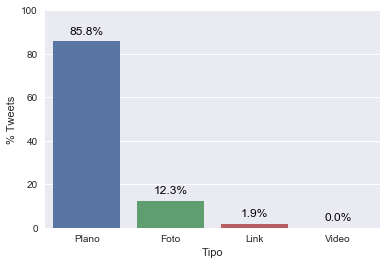

In [22]:
dis = pd.DataFrame(
    {
        'Tipo': ['Plano', 'Link', 'Foto', 'Video'],
        '% Tweets': [
            round(100*(len(pt)/tot_tweets_anr_no_rt),1),
            round(100*(len(lt)/tot_tweets_anr_no_rt),1),
            round(100*(len(pht)/tot_tweets_anr_no_rt),1),
            round(100*(len(vt)/tot_tweets_anr_no_rt),1)
        ]
    }
)
fig = sns.barplot(x='Tipo', y='% Tweets', data=dis, order=['Plano', 'Foto', 'Link', 'Video'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("{0}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,100) #To make space for the annotations
plt.show()

### Honor Colorado

In [29]:
tot_tws_hc = len(original_tweets_hc) + len(replies_hc) + len(quotes_hc)

### Planos

Solo texto sin links, fotos, o videos.

In [30]:
pt = db.get_plain_tweets(**{'partido': 'anr', 'movimiento': 'honor colorado'})

In [31]:
print('Existen {0} tweets planos. Representan el {1}% del total de tweets originales, replies, y quotes de HC.'.
      format(len(pt), round(100*(len(pt)/tot_tws_hc),1)))

Existen 31189 tweets planos. Representan el 86.7% del total de tweets originales, replies, y quotes de HC.


### Links

Tweets con links

In [32]:
lt = db.get_tweets_with_links(**{'partido': 'anr', 'movimiento': 'honor colorado'})

In [44]:
print('Existen {0} tweets con links. Representan el {1}% del total de tweets originales, replies, y quotes de HC.'.
      format(len(lt), round(100*(len(lt)/tot_tws_hc),1)))

Existen 503 tweets con links. Representan el 1.4% del total de tweets originales, replies, y quotes de HC.


#### Top-10 dominios más frecuentes

In [60]:
la = LinkAnalyzer()
domains_url, domains = la.get_domains_and_freq(save_to_file=False, 
                                               **{'partido': 'anr', 'movimiento': 'honor colorado'})

In [61]:
domains_freq = pd.DataFrame(domains, columns=['Domain','Tweets'])
domains_freq[:10]

,Domain,Tweets
0,youtube,133
1,abc,57
2,facebook,51
3,ultimahora,16
4,efe,16
5,lavozdigital,12
6,rdn,8
7,santipresidente,8
8,twitter,7
9,780am,5


### Fotos

Tweets con fotos

In [35]:
pht = db.get_tweets_with_photo(**{'partido': 'anr', 'movimiento': 'honor colorado'})

In [45]:
print('Existen {0} tweets con fotos. Representan el {1}% del total de tweets originales, replies, y quotes de HC.'.
      format(len(pht), round(100*(len(pht)/tot_tws_hc),1)))

Existen 4296 tweets con fotos. Representan el 11.9% del total de tweets originales, replies, y quotes de HC.


### Videos

Tweets con video

In [37]:
vt = db.get_tweets_with_video(**{'partido': 'anr', 'movimiento': 'honor colorado'})

In [46]:
print('Existen {0} tweets videos. Representan el {1}% del total de tweets originales, replies, y quotes de HC.'.
      format(len(vt), round(100*(len(vt)/tot_tws_hc),1)))

Existen 0 tweets videos. Representan el 0.0% del total de tweets originales, replies, y quotes de HC.


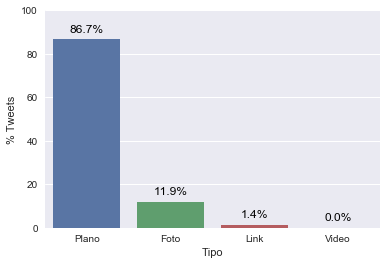

In [39]:
dis = pd.DataFrame(
    {
        'Tipo': ['Plano', 'Link', 'Foto', 'Video'],
        '% Tweets': [
            round(100*(len(pt)/tot_tws_hc),1),
            round(100*(len(lt)/tot_tws_hc),1),
            round(100*(len(pht)/tot_tws_hc),1),
            round(100*(len(vt)/tot_tws_hc),1)
        ]
    }
)
fig = sns.barplot(x='Tipo', y='% Tweets', data=dis, order=['Plano', 'Foto', 'Link', 'Video'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("{0}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,100) #To make space for the annotations
plt.show()

### Colorado Añeteté

In [41]:
tot_tws_ca = len(original_tweets_ca) + len(replies_ca) + len(quotes_ca)

### Planos

Solo texto sin links, fotos, o videos.

In [47]:
pt = db.get_plain_tweets(**{'partido': 'anr', 'movimiento': 'colorado añetete'})

In [48]:
print('Existen {0} tweets planos. Representan el {1}% del total de tweets originales, replies, y quotes de CA.'.
      format(len(pt), round(100*(len(pt)/tot_tws_ca),1)))

Existen 18040 tweets planos. Representan el 84.1% del total de tweets originales, replies, y quotes de CA.


### Links

Tweets con links

In [49]:
lt = db.get_tweets_with_links(**{'partido': 'anr', 'movimiento': 'colorado añetete'})

In [54]:
print('Existen {0} tweets con links. Representan el {1}% del total de tweets originales, replies, y quotes de CA.'.
      format(len(lt), round(100*(len(lt)/tot_tws_ca),1)))

Existen 617 tweets con links. Representan el 2.9% del total de tweets originales, replies, y quotes de CA.


#### Top-10 dominios más frecuentes

In [62]:
la = LinkAnalyzer()
domains_url, domains = la.get_domains_and_freq(save_to_file=False, 
                                               **{'partido': 'anr', 'movimiento': 'colorado añetete'})

In [63]:
domains_freq = pd.DataFrame(domains, columns=['Domain','Tweets'])
domains_freq[:10]

,Domain,Tweets
0,messenger,154
1,facebook,48
2,abc,34
3,ultimahora,22
4,youtube,20
5,radio1000,18
6,instagram,11
7,lavozdigital,10
8,nanduti,8
9,goo,7


### Fotos

Tweets con fotos

In [52]:
pht = db.get_tweets_with_photo(**{'partido': 'anr', 'movimiento': 'colorado añetete'})

In [55]:
print('Existen {0} tweets con fotos. Representan el {1}% del total de tweets originales, replies, y quotes de CA.'.
      format(len(pht), round(100*(len(pht)/tot_tws_ca),1)))

Existen 2791 tweets con fotos. Representan el 13.0% del total de tweets originales, replies, y quotes de CA.


### Videos

Tweets con video

In [56]:
vt = db.get_tweets_with_video(**{'partido': 'anr', 'movimiento': 'colorado añetete'})

In [57]:
print('Existen {0} tweets planos. Representan el {1}% del total de tweets originales, replies, y quotes de CA.'.
      format(len(vt), round(100*(len(vt)/tot_tws_ca),1)))

Existen 0 tweets planos. Representan el 0.0% del total de tweets originales, replies, y quotes de CA.


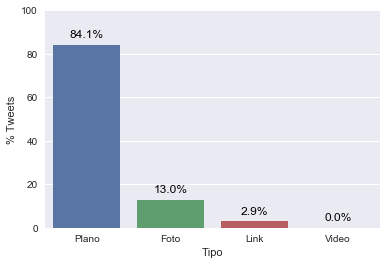

In [59]:
dis = pd.DataFrame(
    {
        'Tipo': ['Plano', 'Link', 'Foto', 'Video'],
        '% Tweets': [
            round(100*(len(pt)/tot_tws_ca),1),
            round(100*(len(lt)/tot_tws_ca),1),
            round(100*(len(pht)/tot_tws_ca),1),
            round(100*(len(vt)/tot_tws_ca),1)
        ]
    }
)
fig = sns.barplot(x='Tipo', y='% Tweets', data=dis, order=['Plano', 'Foto', 'Link', 'Video'])
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("{0}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,100) #To make space for the annotations
plt.show()

## Hashtags más populares

Lista de hashtag más comunes utilizados en tweets relacionados a los movimientos Honor Colorado y Colorado Añeteté.

### Top-5 hashtags relacionado a Honor Colorado

In [53]:
additional_args = {'include_candidate':False, 'candidate_handler':'SantiPenap'}
hashtags_hc = db.get_hashtags_by_movement('honor colorado', **additional_args)
hashtags_populares_hc = []
sum_total = 0
for i in range(5):
    hashtag = hashtags_hc[i]
    sum_total += hashtag['count']
    hashtag_dict = {'1. Hashtag': '#' + hashtag['hashtag'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_hc.append(hashtag_dict)
pd.DataFrame(hashtags_populares_hc)

,1. Hashtag,2. Cantidad de Tweets
0,#Lista2,3184
1,#SantiPresidente,3167
2,#SigamosConversando,1294
3,#HonorColorado,979
4,#ParaguayElige,759


### Top-5 hashtags relacionados a Colorado Añeteté

In [54]:
additional_args = {'include_candidate':False, 'candidate_handler':'MaritoAbdo'}
hashtags_ca = db.get_hashtags_by_movement('colorado añetete', **additional_args)
hashtags_populares_ca = []
for i in range(5):
    hashtag = hashtags_ca[i]
    hashtag_dict = {'1. Hashtag': '#' + hashtag['hashtag'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_ca.append(hashtag_dict)
pd.DataFrame(hashtags_populares_ca)

,1. Hashtag,2. Cantidad de Tweets
0,#ParaguayDeLaGente,8421
1,#MaritoImparable,1404
2,#MaritoDeLaGente,1402
3,#ParaguayElige,645
4,#MaritoPresidente,560


## Cantidad de tuiteros por movimiento

Análisis de la cantidad de perfiles que publicaron tweets conteniendo los hashtags de los movimientos. Los conjuntos de perfiles no son mutuamente excluyente. En otros palabras, pueden existir perfiles que hayan realizado publicado tweets usando hashtags vinculados a ambos movimientos. 

### Honor Colorado

In [4]:
users = dbu.get_users_and_activity(**{'partido': 'anr', 'movimiento': 'honor colorado'})
print('{0} usuarios tuitearon utilizando hashtags vinculados al movimiento Honor Colorado'.
      format(len(users)))

15663 usuarios tuitearon utilizando hashtags vinculados al movimiento Honor Colorado


#### Top-10 más activos con sus principales características y actividades

In [7]:
tuiteros_hc = []
for user in users:
    tuitero_hc = {'1.Usuario': user['screen_name'], 
                  '3.Tweets': user['tweets'],
                  '4.Originales': user['original_tweets'],
                  '5.Retweets': user['rts'],
                  '6.Quotes': user['qts'],
                  '7.Replies': user['rps'],
                  '8.Followers': user['followers'],
                  '9.Friends': user['friends'],
                  '10. PBB': user['pbb']}
    tuiteros_hc.append(tuitero_hc)
df_tuiteros_hc = pd.DataFrame(tuiteros_hc)
df_tuiteros_hc[0:10]

,1.Usuario,10. PBB,3.Tweets,4.Originales,5.Retweets,6.Quotes,7.Replies,8.Followers,9.Friends
0,CESARSANCHEZ553,1.191947,952,0,754,0,198,17,132
1,Norabeli,0.385551,941,1,734,2,204,1387,930
2,CesarSanchez636,0.851941,802,0,646,0,156,155,651
3,Michelec1954,0.574453,707,0,0,575,132,708,1484
4,gladysgulino,0.348731,548,0,548,0,0,471,93
5,Radio970AM,0.216336,535,96,11,5,423,211891,875
6,delgapy2016,0.812437,529,0,485,0,44,79,461
7,SemideiOmar,0.263063,527,8,3,0,516,419,277
8,ArturoO22734057,0.736119,516,1,510,0,5,192,825
9,JavierSanchezPy,0.128002,434,237,136,4,57,11151,1373


### Colorado Añeteté

In [8]:
users_ca = dbu.get_users_and_activity(**{'partido': 'anr', 'movimiento': 'colorado añetete'})
print('{0} usuarios tuitearon utilizando hashtags vinculados al movimiento Colorado Aneteté'.
      format(len(users_ca)))

7484 usuarios tuitearon utilizando hashtags vinculados al movimiento Colorado Aneteté


#### Top-10 más activos y sus actividades

In [9]:
tuiteros_ca = []
for user_ca in users_ca:
    tuitero_ca = {'1.Usuario': user_ca['screen_name'], 
                  '3.Tweets': user_ca['tweets'],
                  '4.Originales': user_ca['original_tweets'],
                  '5.Retweets': user_ca['rts'],
                  '6.Quotes': user_ca['qts'],
                  '7.Replies': user_ca['rps'],
                  '8.Followers': user_ca['friends'],
                  '9.Friends': user_ca['followers'],
                  '10. PBB': user_ca['pbb']}
    tuiteros_ca.append(tuitero_ca)
df_tuiteros_ca = pd.DataFrame(tuiteros_ca)
df_tuiteros_ca[0:10]

,1.Usuario,10. PBB,3.Tweets,4.Originales,5.Retweets,6.Quotes,7.Replies,8.Followers,9.Friends
0,Paraguaynosune,0.424198,856,0,856,0,0,174,520
1,Beatriz20D,0.744348,854,0,743,2,109,739,210
2,Solmelga,0.294215,540,138,330,1,71,4790,5323
3,1000_am,0.132465,421,148,78,1,194,368,93115
4,felixugarte,0.304890,373,0,367,0,6,369,499
5,LaJusticierra,0.322528,344,2,258,0,84,1262,3344
6,MaritoAbdo,0.000000,270,228,42,0,0,501,101326
7,jjrios_bogado,0.421662,264,29,233,0,2,777,1870
8,EDITHVILLA3,0.477252,246,5,193,0,48,1117,598
9,totoclerch,0.318271,245,5,168,4,68,1025,1580


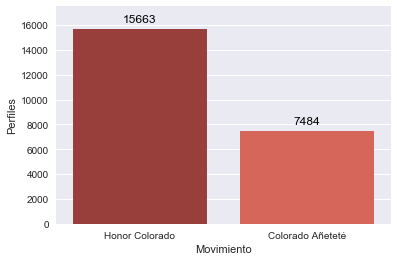

In [10]:
tuiteros_por_movimiento = pd.DataFrame({
    'Movimiento': ['Honor Colorado', 'Colorado Añeteté'],
    'Perfiles': [len(users), len(users_ca)]
}, index=['hc', 'ca'])
fig = sns.barplot(x='Movimiento', y='Perfiles', data=tuiteros_por_movimiento, palette="Reds_d")
for p in fig.patches:
    fig.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,17500) #To make space for the annotations
plt.show()

Como se podría esperar la cantidad de perfiles que publicaron tweets utilizando hashtags vinculados al movimiento **`Honor Colorado`** (15.663, 67% del total de perfiles vinculados a la ANR) es ampliamente superior al de **`Colorado Añeteté`** (7.484, 32% del total ANR). **Por cada tuitero de `Colorado Añeteté` existen 2 tuiteros de `Honor Colorado`**. La diferencia en la cantidad de tuiteros se puede percibir también en la cantidad de tweets de cada movimiento; **`Honor Colorado`** tiene casi el doble de tweets que **`Colorado Añeteté`**. Un aspecto a notar aquí es que existen 98 perfiles que publicaron tweets usando hashtags relacionados al partido colorado pero a ningún movimiento en particular.

Otro aspecto destacable es el tipo de actividad que realizan tanto los tuiteros. Comparando las actividades de los perfiles más activos en ambos movimiento se nota que en la mayoría de los casos, **los tuiteros más activos no realizan publicaciones propias** sino más bien se ocupan de realizar retweets. En otras palabras, la principal actividad de estos usuarios es amplificar y promocionar información relacionada a sus intereses. **Este comportamiento es típico de bots y cuentas falsas**. Los perfiles más activos de **`Honor Colorado`** se destacan además por su importante volumen de respuestas, esto puede deberse a que estas cuentas se utilizaron prinicipalmente para entrar en debates o responder a publicaciones en contra de los intereses de este movimiento. 

## Análisis de bots

Para los fines de este análisis consideraremos que un perfil muestra aparentes comportamientos de bot/cuenta falsa si este se encuentra dentro del 25% de los perfiles con mayores probabilidades de ser un bot. Para ello a continuación calculamos el límite del tercer cuantil en la distribución de probabalidades de ser bot.

In [246]:
all_users = dbu.find_all(projection={'screen_name': 1, 'bot_analysis.pbb': 1, '_id': 0, 'party': 1, 'movement': 1})
l_all_users = [{'screen_name': user['screen_name'], 'pbb': user['bot_analysis']['pbb'], 
                'party': user['party'], 'movement': user['movement']} for user in all_users]
all_users_df = pd.DataFrame(l_all_users)
quantile_75 = all_users_df.pbb.quantile(.75)

In [248]:
all_users_df.head()

,movement,party,pbb,screen_name
0,honor colorado,anr,1.191947,CESARSANCHEZ553
1,honor colorado,anr,0.385551,Norabeli
2,colorado añetete,anr,0.424198,Paraguaynosune
3,colorado añetete,anr,0.744348,Beatriz20D
4,honor colorado,anr,0.851941,CesarSanchez636


### Los bots de HC

In [22]:
bots_hc = df_tuiteros_hc[df_tuiteros_hc['10. PBB']>quantile_75]

In [23]:
tot_bots_hc = bots_hc.shape[0]
tot_perf_hc = df_tuiteros_hc.shape[0]
per_bots_hc = round(100*tot_bots_hc/tot_perf_hc,0)
print('Existen {0} bots en el movimiento HC, {1}% del total'.format(tot_bots_hc, per_bots_hc))

Existen 3503 bots en el movimiento HC, 22.0% del total


#### Características de los bots HC

In [24]:
ch_bots_hc = {
    '1.Total Tweets': sum(bots_hc['3.Tweets']),
    '2.Tweets Originales': sum(bots_hc['4.Originales']),
    '3.Retweets': sum(bots_hc['5.Retweets']),
    '4.Quotes': sum(bots_hc['6.Quotes']),
    '5.Replies': sum(bots_hc['7.Replies'])
}
pd.DataFrame(ch_bots_hc, index=[''])

,1.Total Tweets,2.Tweets Originales,3.Retweets,4.Quotes,5.Replies
,27145,398,17535,77,9135


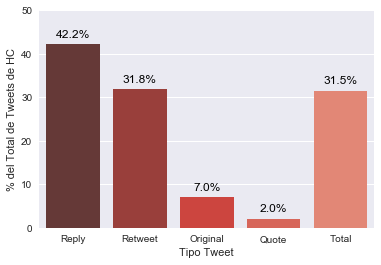

In [42]:
bot_per_of_total = pd.DataFrame(
    {
        'Tipo Tweet': ['Original', 'Retweet', 'Quote', 'Reply', 'Total'],
        '% del Total de Tweets de HC': [
            round(100*(sum(bots_hc['4.Originales'])/num_original_tweets_hc),1),
            round(100*(sum(bots_hc['5.Retweets'])/num_retweets_hc),1),
            round(100*(sum(bots_hc['6.Quotes'])/num_quotes_hc),1),
            round(100*(sum(bots_hc['7.Replies'])/num_replies_hc),1),
            round(100*(sum(bots_hc['3.Tweets'])/tweets_hc.count()),1)
        ]
    }
)
fig = sns.barplot(x='Tipo Tweet', y='% del Total de Tweets de HC', 
                  data=bot_per_of_total, 
                  order=['Reply', 'Retweet', 'Original', 'Quote', 'Total'],
                  palette="Reds_d")
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("{0}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,50) #To make space for the annotations
plt.show()

#### Análisis de los reply de los bots

In [43]:
replies_bots_hc = db.search({'tweet_obj.retweeted_status': {'$exists': 0},
                             'tweet_obj.in_reply_to_status_id_str': {'$ne': None},
                             'tweet_obj.is_quote_status': False,
                             'tweet_obj.user.screen_name': {'$in': list(bots_hc['1.Usuario'])}})

In [44]:
total_replies_bots_hc = replies_bots_hc.count()
pos_replies, neu_replies, neg_replies = 0, 0, 0
for reply in replies_bots_hc:
    if reply['sentimiento']['tono'] == 'negative':
        neg_replies += 1
    if reply['sentimiento']['tono'] == 'neutral':
        neu_replies += 1
    if reply['sentimiento']['tono'] == 'positive':
        pos_replies += 1
print('Total replies: {0}'.format(total_replies_bots_hc))
print('Positive replies: {0}'.format(pos_replies))
print('Neutral replies: {0}'.format(neu_replies))
print('Negative replies: {0}'.format(neg_replies))

Total replies: 8946
Positive replies: 2498
Neutral replies: 4897
Negative replies: 1551


### Los bots Añeteté

In [46]:
bots_ca = df_tuiteros_ca[df_tuiteros_ca['10. PBB']>quantile_75]

In [47]:
tot_bots_ca = bots_ca.shape[0]
tot_perf_ca = df_tuiteros_ca.shape[0]
per_bots_ca = round(100*tot_bots_ca/tot_perf_ca,0)
print('Existen {0} bots en el movimiento Colorado Añetete, {1}% del total'.format(tot_bots_ca, per_bots_ca))

Existen 2389 bots en el movimiento Colorado Añetete, 32.0% del total


#### Características bots Añeteté

In [48]:
ch_bots_ca = {
    '1.Total Tweets': sum(bots_ca['3.Tweets']),
    '2.Tweets Originales': sum(bots_ca['4.Originales']),
    '3.Retweets': sum(bots_ca['5.Retweets']),
    '4.Quotes': sum(bots_ca['6.Quotes']),
    '5.Replies': sum(bots_ca['7.Replies'])
}
pd.DataFrame(ch_bots_ca, index=[''])

,1.Total Tweets,2.Tweets Originales,3.Retweets,4.Quotes,5.Replies
,15324,1119,9816,316,4073


#### Análisis de los reply de los bots

In [49]:
replies_bots_ca = db.search({'tweet_obj.retweeted_status': {'$exists': 0},
                             'tweet_obj.in_reply_to_status_id_str': {'$ne': None},
                             'tweet_obj.is_quote_status': False,
                             'tweet_obj.user.screen_name': {'$in': list(bots_ca['1.Usuario'])}})

In [50]:
total_replies_bots_ca = replies_bots_ca.count()
pos_replies, neu_replies, neg_replies = 0, 0, 0
for reply in replies_bots_ca:
    if reply['sentimiento']['tono'] == 'negative':
        neg_replies += 1
    if reply['sentimiento']['tono'] == 'neutral':
        neu_replies += 1
    if reply['sentimiento']['tono'] == 'positive':
        pos_replies += 1
print('Total replies: {0}'.format(total_replies_bots_ca))
print('Positive replies: {0}'.format(pos_replies))
print('Neutral replies: {0}'.format(neu_replies))
print('Negative replies: {0}'.format(neg_replies))

Total replies: 3952
Positive replies: 1233
Neutral replies: 2133
Negative replies: 586


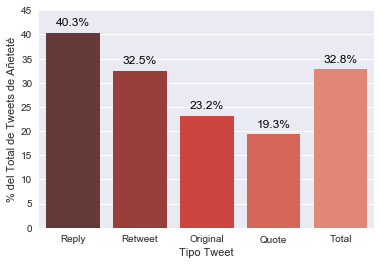

In [53]:
bot_per_of_total = pd.DataFrame(
    {
        'Tipo Tweet': ['Original', 'Retweet', 'Quote', 'Reply', 'Total'],
        '% del Total de Tweets de Añeteté': [
            round(100*(sum(bots_ca['4.Originales'])/num_original_tweets_ca),1),
            round(100*(sum(bots_ca['5.Retweets'])/num_retweets_ca),1),
            round(100*(sum(bots_ca['6.Quotes'])/num_quotes_ca),1),
            round(100*(sum(bots_ca['7.Replies'])/num_replies_ca),1),
            round(100*(sum(bots_ca['3.Tweets'])/tweets_ca.count()),1)
        ]
    }
)
fig = sns.barplot(x='Tipo Tweet', y='% del Total de Tweets de Añeteté', 
                  data=bot_per_of_total, 
                  order=['Reply', 'Retweet', 'Original', 'Quote', 'Total'],
                  palette="Reds_d")
ax=fig
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("{0}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,45) #To make space for the annotations
plt.show()

In [54]:
bot_per_of_total = pd.DataFrame(
    {
        'Tipo Tweet': ['Original', 'Retweet', 'Quote', 'Reply', 'Total', 
                       'Original', 'Retweet', 'Quote', 'Reply', 'Total'],
        '% del Total de Tweets del Movimiento': [
            round(100*(sum(bots_ca['4.Originales'])/num_original_tweets_ca),1),
            round(100*(sum(bots_ca['5.Retweets'])/num_retweets_ca),1),
            round(100*(sum(bots_ca['6.Quotes'])/num_quotes_ca),1),
            round(100*(sum(bots_ca['7.Replies'])/num_replies_ca),1),
            round(100*(sum(bots_ca['3.Tweets'])/tweets_ca.count()),1),
            round(100*(sum(bots_hc['4.Originales'])/num_original_tweets_hc),1),
            round(100*(sum(bots_hc['5.Retweets'])/num_retweets_hc),1),
            round(100*(sum(bots_hc['6.Quotes'])/num_quotes_hc),1),
            round(100*(sum(bots_hc['7.Replies'])/num_replies_hc),1),
            round(100*(sum(bots_hc['3.Tweets'])/tweets_hc.count()),1)
        ],
        'Movimiento': ['Colorado Añeteté', 'Colorado Añeteté', 'Colorado Añeteté', 'Colorado Añeteté', 
                       'Colorado Añeteté',
                       'Honor Colorado', 'Honor Colorado', 'Honor Colorado', 'Honor Colorado', 'Honor Colorado']
    }
)

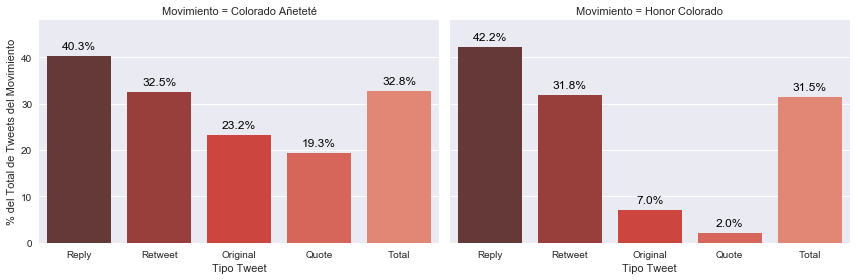

In [57]:
plt.figure(figsize=(20,12))
g = sns.FacetGrid(bot_per_of_total, col="Movimiento", height=4, aspect=1.5)
g.map(sns.barplot, 'Tipo Tweet', '% del Total de Tweets del Movimiento', 
      order=['Reply', 'Retweet', 'Original', 'Quote', 'Total'],
      palette="Reds_d")
#annotate axis = seaborn axis
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate("{0}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                     textcoords='offset points')
g.set(ylim=(0, 48))
plt.show()
g.savefig("bots_por_movimiento.png", dpi=200, quality=95)

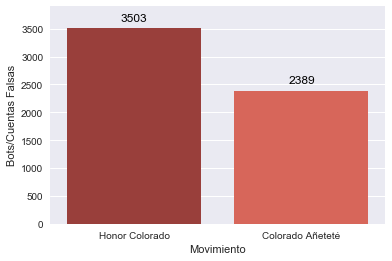

In [61]:
bots_ambos = pd.DataFrame(
    {
        'Movimiento': ['Colorado Añeteté', 'Honor Colorado'],
        'Bots/Cuentas Falsas': [tot_bots_ca, tot_bots_hc]
    }
)
fig = sns.barplot(x='Movimiento', y='Bots/Cuentas Falsas', data=bots_ambos, palette="Reds_d",
                  order=['Honor Colorado', 'Colorado Añeteté'])
for p in fig.patches:
    fig.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,3900) #To make space for the annotations
plt.show()

## Red de interacciones entre perfiles

Como parte del estudio realizamos un análisis sobre la red de perfiles que publicaron tweets utilizando hashtags relacionados a la interna del partido colorado. El análisis lo centramos en las interacciones entre los perfiles, no en las relaciones entre ellos (seguidores, seguidos). Consideramos que A tuvo una interacción con B si i) publicó un tweet mencionando a B; ii) retuiteo un tweet publicado por B; iii) citó (quote) un tweet publicado por B; iv) respondió un tweet publicado por B.

Al generar la **red de interacciones** encontramos que de la misma forman parte **23.710 perfiles** que se comunicaron entre si 84.996 veces en el período de Noviembre a Enero 2018, el promedio de interacciones de un perfil en la red es 3,58. La cantidad de perfiles en la red supera en 465 el total de perfiles relacionados a la ANR. Esto se debe principalmente a que la red también incluye perfiles vinculados a otros partidos que realizaron interacciones con los de la ANR.

El perfil `CESARSANCHEZ553` fue el que más interacciones generó (463), seguido por `CesarSanchez636` (378), y `Norabeli` (354), todos vinculados principalmente al movimiento `Honor Colorado`. `Santula` (4.661), `MaritoAbdo` (4.636), y `SantiPenap` (4.532) fueron los perfiles que más interacciones recibieron, esto es menciones, retweets, replies, quotes. Es interesante notar el rol tan preponderante del periodista Santiago González (Santula). En el último mes de campaña Santula atrajo inclusive más interacciones que los mismos candidatos a la presidencia.

![Red Interacciones](../../sna/img/internas-anr-red.png)

El gráfico muestra la parte más significativa de la red de interacciones. Los perfiles son ilustrados por medio de círculos, los cuales toman principalmente dos colores. Los circulos `rojo claro` represetan perfiles cuyas interacciones contenian mayoritariamente hashtags o menciones asociadas al movimiento **`Honor Colorado`**. El `rojo oscuro` se utiliza para respresentar perfiles que principalmente participaron de comunicaciones donde se utilizaron hashtags o menciones vinculadas a la campaña del movimiento **`Colorado Añeteté`**. Existen círculo de otros colores como azul, naranja, o verde utilizados para representar otros movimientos de la ANR como el progresista colorado pero estos son irrelevantes dentro de la red.

El **tamaño de los círculos** es proporcional al número de interacciones del perfil. Así perfiles que representados por círculos grandes (p. ej., MaritoAbdo, Horacio_Cartes, SantiPenap) son muy relevantes dentro de la red por la gran cantidad de interacciones en las que se vieron envueltos. Además de tamaño y color, los círculos se encuentran etiquetados con el nombre de perfil. El tamaño de la etiqueta es proporcional al tamaño del círculo, así perfiles importantes, con muchas interacciones, tienen asociados etiquetas más grandes.

Como era de esperarse la red está dominada por perfiles que utilizaron en sus interacciones hashtags vinculados al movimiento **`Honor Colorado`**. Vimos anteriormente que estos son mayoría en el conjunto de datos. Los perfiles del movimiento **`Colorado Añeteté`** se encuentran principalmente en un sector acotado de la red y muy cercanos al perfil del candidato de este movimiento. Otra característica esperable de la red es la influencia de los perfiles de los candidatos a presidente, **Mario Abdo (`MaritoAbdo`)** y **Santiago Peña (`SantiPenap`)**. Es de notar también la importancia en la red del líder del movimiento **`Honor Colorado`**, **Horacio Cartes (`Horacio_Cartes`)**, demostrando que se vió involucrado --- esto es, menciones, retweets, replies, etc --- en gran parte de las interacciones, especialmente en las de su movimiento.

Un aspecto sorpresivo y a destacar es la importancia en la red de los periodistas **Santiago González (`Santula`)** y **Luis Bareiro (`LuisBareiro`)**. Por el color de los círculos utilizados para representar su perfiles podemos notar que principalmente los mismo se vieron involucrados en interacciones que mayoritariamente incluían hashtags y menciones a los perfiles de los candidatos del movimiento oficialista **`Honor Colorado`**. Considerando la posición crítica de estos periodistas hacia el gobierno, es difícil imaginar que los mismos hayan utilizado twitter para promocionar las candidaturas de este movimiento, es más probable, sin embargo, que González y Bareiro se hayan visto involucrados en discusiones con seguidores de HC a raiz de comentarios críticos hacia el gobierno, el candidato a presidente, o el grupo político ligado a **`Honor Colorado`**. Profundizaremos en este aspecto más adelante.

### Honor Colorado

La red de interacciones del movimiento **`Honor Colorado`** está compuesta por **15.809 perfiles** (66.68% del total) que realizaron 47.436 interacciones (56% del total). En promedio, los perfiles de la red de **`Honor Colorado`** realizan 3 interacciones. `SantiPenap` (4.122), `Santula` (3.490), y `Horacio_Cartes` (3.173) son los tres perfiles que más interacciones recibieron. Lo de Peña y Cartes es entendible, lo de `Santula` es llamativo. Conociendo su postura crítica al candidato oficialista y al gobierno es de suponer que las interacciones no deberieron ser muy positivas. En una misma situación se encuentra Luis Bareiro (`LuisBareiro`), que después del perfil del presidente de la república, es el que más interacciones recibió (2.543).

También es notorio la importancia en la red de perfiles muy críticos al gobierno como el de la Senadora Desireè Masi (`desimasi2`), quién en este período recibió 877 interacciones (menciones, respuestas, citaciones, retweets). También se destaca el perfil del canal de televisión Telefuturo (`TelefuturoInfo`), quién recibió más de 1.000 interacciones de cuentas vinculas al movimiento oficialista. Cabe destacar que la línea editorial del canal Telefuturo fue una de las más críticas al gobierno durante la crisis de la enmienda. El perfil de la radio ABC Cardinal (`ABCCardinal`) y del periodística de esta radio Javier Sánchez (`JavierSanchezPy`) se destacan también como relevantes dentro de la red del movimiento **`Honor Colorado`**.

![Red Interacciones](../../sna/img/internas-anr-hc-red.png)

## Colorado Añeteté

Aproximadamente 33% del total de perfiles (**7.629**) de la red de interacciones de la ANR está compuesta por cuenta relacionadas al movimiento **`Colorado Añeteté`**. Estos perfiles interactuaron 14.333 veces durante el último mes de campaña y los primeros días de Enero de 2018. En promedio los perfiles realizaron 1.87 interacciones. Como era de esperarse y se puede notar en la gráfica, la red de **`Colorado Añeteté`** está fuertemente centrada en la figura del candidato a presidente Mario Abdo (`MaritoAbdo`). Esto lo confirman las casi 3.500 interacciones que recibió.

Aunque muy por debajo de Abdo, otros perfiles en la red de **`Colorado Añeteté`** que recibieron una importante cantidad de interacciones son `JuanAfara` (485), `enriquevp` (450), y `minaftv` (324). `Paraguaynosune` es el perfil que más interacciones generó (167) seguido de `Solmega` (92) y `Beatriz20D` (75).

![Red Interacciones](../../sna/img/internas-anr-ca-red.png)

## Interacciones alrededor de perfiles relevantes

Aquí analizaremos las interacciones alrededor de perfiles relevantes en la red pero no directamente vinculados a la campaña electoral de las internas de la ANR, p.ej., `Santula`, `LuisBareiro`, `enriquevp`, `desimasi2`.

### Santiago González (Santula)

In [302]:
na = NetworkAnalyzer()
inter_santula = na.get_out_interactions('Santula')

#### Interacciones generadas

Las interacciones generadas son todas aquellas publicaciones realizadas por el usuario. Esto comprende los tweets originales, los retweets, las respuestas a tweets, y las citaciones

In [303]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_santula['out_interactions']['total']['count'], \
             inter_santula['out_interactions']['retweets']['count'], \
             inter_santula['out_interactions']['replies']['count'], \
             inter_santula['out_interactions']['mentions']['count'], \
             inter_santula['out_interactions']['quotes']['count']))

145 tweets; 24 retweets, 6 respuestas, 111 menciones, y 4 citaciones


##### Perfiles más retuiteados

In [21]:
top_rts = []
out_inter_santula = inter_santula['out_interactions']['retweets']['details']
max_iter = 5 if len(out_inter_santula) > 5 else len(out_inter_santula)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_santula[i][0], 
                '2.Total retweets': out_inter_santula[i][1]
               }
    top_rts.append(contacto)
pd.DataFrame(top_rts)

,1.Perfil,2.Total retweets
0,algoandamalpy,12
1,TelefuturoInfo,3
2,juankilezcano,3
3,minaftv,2
4,Santula,1


##### Perfiles más mencionados

In [22]:
top_mts = []
out_inter_santula = inter_santula['out_interactions']['mentions']['details']
max_iter = 5 if len(out_inter_santula) > 5 else len(out_inter_santula)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_santula[i][0], 
                '2.Total menciones': out_inter_santula[i][1]
               }
    top_mts.append(contacto)
pd.DataFrame(top_mts)

,1.Perfil,2.Total menciones
0,Telefuturo,38
1,MaritoAbdo,28
2,SantiPenap,24
3,EfrainAlegre,13
4,nanduti,2


##### Perfiles más citados

In [23]:
top_qts = []
out_inter_santula = inter_santula['out_interactions']['quotes']['details']
max_iter = 5 if len(out_inter_santula) > 5 else len(out_inter_santula)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_santula[i][0], 
                '2.Total citas': out_inter_santula[i][1]
               }
    top_qts.append(contacto)
pd.DataFrame(top_qts)

,1.Perfil,2.Total citas
0,MoWet2015,1
1,UltimaHoracom,1
2,algoandamalpy,1
3,MaritoAbdo,1


##### Perfiles a quiénes más respondió

In [25]:
top_rps = []
out_inter_santula = inter_santula['out_interactions']['replies']['details']
max_iter = 5 if len(out_inter_santula) > 5 else len(out_inter_santula)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_santula[i][0], 
                '2.Total respuestas': out_inter_santula[i][1]
               }
    top_rps.append(contacto)
pd.DataFrame(top_rps)

,1.Perfil,2.Total respuestas
0,josemfer,3
1,PolemicaPy,1
2,MariaGodoyMora1,1
3,majozpires,1


Lo más resaltante de las interacciones de `@Santula` es que durante el período de muestreo un importante número de sus publicaciones se centraron en tweets que mencionaron a los principales pre-candidatos a la presidencia de la república, `Mario Abdo Benítez`, `Santiago Peña`, y `Efrain Alegre`.

#### Interacciones recibidas

Las interacciones recibidas corresponde a todos aquellos tweets donde se menciona al usuario, se cita al usuario, se retuitea o responde a una publicación del usuario.

In [304]:
inter_santula = na.get_in_interactions('Santula')

In [305]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_santula['in_interactions']['total']['count'], \
             inter_santula['in_interactions']['retweets']['count'], \
             inter_santula['in_interactions']['replies']['count'], \
             inter_santula['in_interactions']['mentions']['count'], \
             inter_santula['in_interactions']['quotes']['count']))

7743 tweets; 6000 retweets, 1563 respuestas, 118 menciones, y 62 citaciones


##### Perfiles que más retuiteron sus publicaciones

In [306]:
rts = []
in_inter_santula = inter_santula['in_interactions']['retweets']['details']
sorted_in_interactions = sorted(in_inter_santula.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total retweets': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    rts.append(contacto)
rts_df = pd.DataFrame(rts)
rts_df.head()

,1.Perfil,2.Total retweets,3.PBB
0,ChristianDoldan,32,0.561026
1,christianchena,14,0.306535
2,Norabeli,14,0.385551
3,Beatriz20D,14,0.744348
4,Ever_Caceres,13,0.536960


**¿Cuántos de esos perfiles son bots?**

In [307]:
rt_bots = rts_df[rts_df['3.PBB']>quantile_75]
print('De los {0} perfiles que retuitearon, {1} son bots ({2}%)'.format(rts_df.shape[0], 
                                                                        rt_bots.shape[0],
                                                                        round(100*rt_bots.shape[0]/rts_df.shape[0],0)))

De los 4057 perfiles que retuitearon, 528 son bots (13.0%)


##### Perfiles que más respondieron a sus publicaciones

In [308]:
rps = []
in_inter_santula = inter_santula['in_interactions']['replies']['details']
sorted_in_interactions = sorted(in_inter_santula.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total respuestas': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb']),
                '4.Movimiento': all_users_df[all_users_df['screen_name']==interaction[0]]['movement'].values[0]
               }
    rps.append(contacto)
rps_df = pd.DataFrame(rps)
rps_df.head()

,1.Perfil,2.Total respuestas,3.PBB,4.Movimiento
0,SemideiOmar,10,0.263063,honor colorado
1,MariaelenaSugat,9,2.441203,honor colorado
2,FarinaLfa,9,0.457579,honor colorado
3,SantacruzFISA,8,0.659704,honor colorado
4,RaulOjedaCano2,8,0.308373,colorado añetete


**¿Cuántos de esos perfiles son bots?**

In [309]:
rp_bots = rps_df[rps_df['3.PBB']>quantile_75]
print('De los {0} perfiles que respondieron, {1} son bots ({2}%)'.format(rps_df.shape[0], 
                                                                         rp_bots.shape[0],
                                                                         round(100*rp_bots.shape[0]/rps_df.shape[0],0)))
rp_bots.sort_values('3.PBB', inplace=True, ascending=False)
rp_bots.head()

De los 1135 perfiles que respondieron, 364 son bots (32.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total respuestas,3.PBB,4.Movimiento
683,AndrsEspinola3,1,13.364287,colorado añetete
213,michela19431,2,11.263318,colorado añetete
257,adilsonalamval1,1,10.980786,honor colorado
591,Norma88756536,1,10.500607,colorado añetete
921,josevillalba111,1,9.830137,honor colorado


In [310]:
rp_bots.sort_values('2.Total respuestas', inplace=True, ascending=False)
sub_set_rp_bots = rp_bots.head(50)
sub_set_rp_bots[sub_set_rp_bots['3.PBB']>quantile_75].shape[0]

/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


50

#### ¿Cuántos bots son HC?

In [311]:
rp_bots[rp_bots['4.Movimiento']=='honor colorado'].shape[0]

244

In [130]:
replies_bots = db.search({'tweet_obj.retweeted_status': {'$exists': 0},
                          'tweet_obj.in_reply_to_status_id_str': {'$ne': None},
                          'tweet_obj.in_reply_to_screen_name': {'$eq': 'Santula'},
                          'tweet_obj.is_quote_status': False,
                          'tweet_obj.user.screen_name': {'$in': list(rp_bots['1.Perfil'])}})

In [131]:
total_replies_bots = replies_bots.count()
pos_replies, neu_replies, neg_replies = 0, 0, 0
id_txt_replies = []
for reply in replies_bots:
    if reply['sentimiento']['tono'] == 'negative':
        neg_replies += 1
        if 'full_text' in reply['tweet_obj'].keys():
            id_txt_replies.append({'text': reply['tweet_obj']['full_text'], 
                                   'id': reply['tweet_obj']['id_str'],
                                   'author': reply['tweet_obj']['user']['screen_name']})
        else:
            id_txt_replies.append({'text': reply['tweet_obj']['text'], 
                                   'id': reply['tweet_obj']['id_str'],
                                   'author': reply['tweet_obj']['user']['screen_name']})
    if reply['sentimiento']['tono'] == 'neutral':
        neu_replies += 1
    if reply['sentimiento']['tono'] == 'positive':
        pos_replies += 1
print('Total replies: {0}'.format(total_replies_bots))
print('Positive replies: {0}'.format(pos_replies))
print('Neutral replies: {0}'.format(neu_replies))
print('Negative replies: {0}'.format(neg_replies))

Total replies: 511
Positive replies: 139
Neutral replies: 279
Negative replies: 93


In [132]:
id_txt_replies[:5]

[{'author': '12EspinolaElias',
  'id': '943467558270889984',
  'text': '@Santula @AM_1080 @SantiPenap puto santula puto'},
 {'author': '12EspinolaElias',
  'id': '946732784382595072',
  'text': '@Santula @MaritoAbdo puto'},
 {'author': 'AdelaidaPiris',
  'id': '940760567945547776',
  'text': '@Santula @SantiPenap @solenu @nanduti Que @Santula  vaya a investigar a su jefe Vierci por meter contrabando de azú… https://t.co/Hd0hthnZ5W'},
 {'author': 'Alberto210378',
  'id': '943111976569458688',
  'text': '@Santula @AM_1080 @SantiPenap Jajajaja cada estupidez que dice este Pena'},
 {'author': 'Andyfg89',
  'id': '943102844281946112',
  'text': '@Santula @AM_1080 @SantiPenap Pero si ahora es culpa de ustedes su derrota!!!! De risa es el tema!!!!'}]

##### Perfiles que más mencionaron a Santula

In [312]:
mts = []
in_inter_santula = inter_santula['in_interactions']['mentions']['details']
sorted_in_interactions = sorted(in_inter_santula.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total menciones': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    mts.append(contacto)
mts_df = pd.DataFrame(mts)
mts_df.head()

,1.Perfil,2.Total menciones,3.PBB
0,CarlosZ86636382,8,0.575252
1,Juangpy,7,0.439092
2,_kimberlyxc,5,0.461615
3,josanortiz88,4,0.413341
4,ANIBALCSPDS,4,0.663988


**¿Cuántos de esos perfiles son bots?**

In [313]:
mts_bots = mts_df[mts_df['3.PBB']>quantile_75]
print('De los {0} perfiles que mencionaron, {1} son bots ({2}%)'.format(mts_df.shape[0], 
                                                                         mts_bots.shape[0],
                                                                         round(100*mts_bots.shape[0]/mts_df.shape[0],0)))
mts_bots.sort_values('3.PBB', inplace=True, ascending=False)
mts_bots.head()

De los 76 perfiles que mencionaron, 17 son bots (22.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total menciones,3.PBB
30,brandonortigoz2,1,4.403884
62,PolitologoPerez,1,4.318150
61,Robertogo_py,1,4.216667
47,Irma59952042,1,3.773519
15,JoseElian17,2,2.180561


##### Perfiles que más citaron publicaciones de Santula

In [314]:
qts = []
in_inter_santula = inter_santula['in_interactions']['quotes']['details']
sorted_in_interactions = sorted(in_inter_santula.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total citaciones': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    qts.append(contacto)
qts_df = pd.DataFrame(qts)
qts_df.head()

,1.Perfil,2.Total citaciones,3.PBB
0,heriberto7502,5,0.398463
1,jbenjaminb,2,0.282275
2,narakopguare,2,0.491188
3,cyzal,2,0.392415
4,hova_ata,2,0.226347


**¿Cuántos de esos perfiles son bots?**

In [315]:
qts_bots = qts_df[qts_df['3.PBB']>quantile_75]
print('De los {0} perfiles que citaron, {1} son bots ({2}%)'.format(qts_df.shape[0], 
                                                                         qts_bots.shape[0],
                                                                         round(100*qts_bots.shape[0]/qts_df.shape[0],0)))
qts_bots.sort_values('3.PBB', inplace=True, ascending=False)
qts_bots.head()

De los 54 perfiles que citaron, 4 son bots (7.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total citaciones,3.PBB
11,kukim10,1,0.953852
34,palacios_josee,1,0.781927
32,vbgaikon,1,0.771509
50,richar_benitez,1,0.739714


#### En total, ¿cuántos perfiles del tipo interactuaron con Santula?

In [316]:
# Get list of bots
all_bots_st = []
all_bots_st.extend(list(rt_bots['1.Perfil']))
all_bots_st.extend(list(rp_bots['1.Perfil']))
all_bots_st.extend(list(mts_bots['1.Perfil']))
all_bots_st.extend(list(qts_bots['1.Perfil']))
# Get list of all profiles
all_prof_st = []
all_prof_st.extend(list(rts_df['1.Perfil']))
all_prof_st.extend(list(rps_df['1.Perfil']))
all_prof_st.extend(list(mts_df['1.Perfil']))
all_prof_st.extend(list(qts_df['1.Perfil']))
print('Del total {0} perfiles que interacturaron con Santula, {1} son del tipo bot'.format(
      len(set(all_prof_st)),
      len(set(all_bots_st))))

Del total 5016 perfiles que interacturaron con Santula, 855 son del tipo bot


Casi el 80% (6000 de 7743) de las interacciones recibidas por `Santula` corresponde a retweets de sus publicaciones. Esto demuestra la relevancia de este perfil dentro de la red del movimiento `Honor Colorado`. Conociendo la postura crítica de `Santula` hacia las candidaturas de este movimiento se puede esperar que el contenido de estas publicaciones no hayan sido precisamente de promoción a los candidatos de HC.

Otro aspecto a resaltar es la actividad del perfil `SemideiOmar`, quién respondió a casi el 10% de total de tweets (no retweets) de `Santula`. También existen perfiles con muchas menciones a `Santula` cuyos nombres no parecen ser reales, por ejemplo `CarlosZ86636382`.

### Luis Bareiro (LuisBareiro)

In [286]:
na = NetworkAnalyzer()
inter_bareiro = na.get_out_interactions('LuisBareiro')

#### Interacciones generadas

In [287]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_bareiro['out_interactions']['total']['count'], \
             inter_bareiro['out_interactions']['retweets']['count'], \
             inter_bareiro['out_interactions']['replies']['count'], \
             inter_bareiro['out_interactions']['mentions']['count'], \
             inter_bareiro['out_interactions']['quotes']['count']))

17 tweets; 6 retweets, 10 respuestas, 1 menciones, y 0 citaciones


##### Perfiles más retuiteados

In [33]:
top_rts = []
out_inter_bareiro = inter_bareiro['out_interactions']['retweets']['details']
max_iter = 5 if len(out_inter_bareiro) > 5 else len(out_inter_bareiro)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_bareiro[i][0], 
                '2.Total retweets': out_inter_bareiro[i][1]
               }
    top_rts.append(contacto)
pd.DataFrame(top_rts)

,1.Perfil,2.Total retweets
0,AM_1080,2
1,latelePy,2
2,Santula,1
3,Dii_villalba,1


##### Perfiles a quiénes más respondió

In [288]:
rps = []
out_inter_bareiro = inter_bareiro['out_interactions']['replies']['details']
sorted_out_interactions = sorted(out_inter_bareiro.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_out_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total respuestas': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    rps.append(contacto)
rps_ba_df = pd.DataFrame(rps)
rps_ba_df.head()

,1.Perfil,2.Total respuestas,3.PBB
0,gabiotago,2,0.721404
1,DeaMaldonado,2,0.357405
2,DanielPatioReal,1,0.487682
3,ARDaz82798131,1,3.831324
4,vlamanchao,1,0.456753


**¿Cuántos de esos perfiles son bots?**

In [289]:
rp_ba_bots = rps_ba_df[rps_ba_df['3.PBB']>quantile_75]
print('De los {0} perfiles que respondieron, {1} son bots ({2}%)'.format(rps_ba_df.shape[0], 
                                                                         rp_ba_bots.shape[0],
                                                                         round(100*rp_ba_bots.shape[0]/rps_ba_df.shape[0],0)))
rp_ba_bots.sort_values('3.PBB', inplace=True, ascending=False)
rp_ba_bots.head()

De los 8 perfiles que respondieron, 5 son bots (62.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total respuestas,3.PBB
3,ARDaz82798131,1,3.831324
5,IsidroRicardoV4,1,1.824115
7,jfrancovergara,1,1.748102
6,britez_ortiz1,1,0.899137
0,gabiotago,2,0.721404


#### Interacciones recibidas

In [290]:
inter_bareiro = na.get_in_interactions('LuisBareiro')

In [291]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_bareiro['in_interactions']['total']['count'], \
             inter_bareiro['in_interactions']['retweets']['count'], \
             inter_bareiro['in_interactions']['replies']['count'], \
             inter_bareiro['in_interactions']['mentions']['count'], \
             inter_bareiro['in_interactions']['quotes']['count']))

2938 tweets; 2680 retweets, 207 respuestas, 38 menciones, y 13 citaciones


##### Perfiles que más retuitearon sus publicaciones

In [292]:
rts = []
in_inter_bareiro = inter_bareiro['in_interactions']['retweets']['details']
sorted_in_interactions = sorted(in_inter_bareiro.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total retweets': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    rts.append(contacto)
rts_df = pd.DataFrame(rts)
rts_df.head()

,1.Perfil,2.Total retweets,3.PBB
0,espiridion01,8,0.522269
1,GloriaB2B,2,0.396105
2,curahee343,1,0.714146
3,PilarAlonso92,1,0.750776
4,caroberdoy,1,0.336212


**¿Cuántos de esos perfiles son bots?**

In [293]:
rt_bots = rts_df[rts_df['3.PBB']>quantile_75]
print('De los {0} perfiles que retuitearon, {1} son bots ({2}%)'.format(rts_df.shape[0], 
                                                                        rt_bots.shape[0],
                                                                        round(100*rt_bots.shape[0]/rts_df.shape[0],0)))

De los 2672 perfiles que retuitearon, 324 son bots (12.0%)


##### Perfiles que más respondieron a sus publicaciones

In [294]:
rps = []
in_inter_bareiro = inter_bareiro['in_interactions']['replies']['details']
sorted_in_interactions = sorted(in_inter_bareiro.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total respuestas': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb']),
                '4.Movimiento': all_users_df[all_users_df['screen_name']==interaction[0]]['movement'].values[0]
               }
    rps.append(contacto)
rps_df = pd.DataFrame(rps)
rps_df.head()

,1.Perfil,2.Total respuestas,3.PBB,4.Movimiento
0,rey_europa,5,1.393175,honor colorado
1,britez_ortiz1,3,0.899137,honor colorado
2,DeaMaldonado,3,0.357405,honor colorado
3,Vctor84855402,2,3.500665,honor colorado
4,Py_retrocede,2,6.596651,honor colorado


**¿Cuántos de esos perfiles son bots?**

In [295]:
rp_bots = rps_df[rps_df['3.PBB']>quantile_75]
print('De los {0} perfiles que respondieron, {1} son bots ({2}%)'.format(rps_df.shape[0], 
                                                                         rp_bots.shape[0],
                                                                         round(100*rp_bots.shape[0]/rps_df.shape[0],0)))

De los 189 perfiles que respondieron, 75 son bots (40.0%)


In [263]:
sub_set_rp_bots = rp_bots.head(50)
sub_set_rp_bots.sort_values('2.Total respuestas', inplace=True, ascending=False)
sub_set_rp_bots[sub_set_rp_bots['3.PBB']>quantile_75].shape[0]
sub_set_rp_bots

/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,1.Perfil,2.Total respuestas,3.PBB,4.Movimiento
0,rey_europa,5,1.393175,honor colorado
1,britez_ortiz1,3,0.899137,honor colorado
3,Vctor84855402,2,3.500665,honor colorado
4,Py_retrocede,2,6.596651,honor colorado
6,ARDaz82798131,2,3.831324,honor colorado
7,gabiotago,2,0.721404,honor colorado
11,nicomartinezpy,2,0.855605,honor colorado
12,gladis_ge,2,0.916297,honor colorado
94,jorge_sdg7,1,0.753966,honor colorado
100,Magni95990910,1,1.978191,colorado añetete


#### ¿Cuántos bots son HC?

In [296]:
rp_bots[rp_bots['4.Movimiento']=='honor colorado'].shape[0]

66

In [158]:
replies_bots = db.search({'tweet_obj.retweeted_status': {'$exists': 0},
                          'tweet_obj.in_reply_to_status_id_str': {'$ne': None},
                          'tweet_obj.in_reply_to_screen_name': {'$eq': 'LuisBareiro'},
                          'tweet_obj.is_quote_status': False,
                          'tweet_obj.user.screen_name': {'$in': list(rp_bots['1.Perfil'])}})

In [159]:
total_replies_bots = replies_bots.count()
pos_replies, neu_replies, neg_replies = 0, 0, 0
id_txt_replies = []
for reply in replies_bots:
    if reply['sentimiento']['tono'] == 'negative':
        neg_replies += 1
        if 'full_text' in reply['tweet_obj'].keys():
            id_txt_replies.append({'text': reply['tweet_obj']['full_text'], 
                                   'id': reply['tweet_obj']['id_str'],
                                   'author': reply['tweet_obj']['user']['screen_name']})
        else:
            id_txt_replies.append({'text': reply['tweet_obj']['text'], 
                                   'id': reply['tweet_obj']['id_str'],
                                   'author': reply['tweet_obj']['user']['screen_name']})
    if reply['sentimiento']['tono'] == 'neutral':
        neu_replies += 1
    if reply['sentimiento']['tono'] == 'positive':
        pos_replies += 1
print('Total replies: {0}'.format(total_replies_bots))
print('Positive replies: {0}'.format(pos_replies))
print('Neutral replies: {0}'.format(neu_replies))
print('Negative replies: {0}'.format(neg_replies))

Total replies: 83
Positive replies: 26
Neutral replies: 43
Negative replies: 14


In [160]:
id_txt_replies[:5]

[{'author': 'ARDaz82798131',
  'id': '942581207950417920',
  'text': '@LuisBareiro @SantiPenap Si la lista 2 de senadores tiene más votos que Santi, hay otra lectura. Si tuvo mas votos que Marito, peor. Ojalá sea castigo, pero dudo.'},
 {'author': 'DorysPy',
  'id': '942555060827054080',
  'text': '@LuisBareiro @SantiPenap Moopioooo....nde vendido!!! Hace 5 horas te tenia como idolo imparcial!!! Pero despues de lo que escuché hoy de la burla q hiciste en telefuturo...me decepcionaste...tu vos tenes q informar no burlarte nde vendido!!!'},
 {'author': 'Giovann55252495',
  'id': '942547940043870208',
  'text': '@LuisBareiro @SantiPenap por una parte cierto pero por otra no un Buen Colorado no le va a votar a un liberal'},
 {'author': 'JuanPor88172473',
  'id': '942823684640780288',
  'text': '@LuisBareiro @SantiPenap Siii legalmente por defender al senador Óscar González daher'},
 {'author': 'JulyMire',
  'id': '942558306677219328',
  'text': '@LuisBareiro @SantiPenap Sr. Cartes, es una 

##### Perfiles que más mencionaron a LuisBareiro

In [297]:
mts = []
in_inter_bareiro = inter_bareiro['in_interactions']['mentions']['details']
sorted_in_interactions = sorted(in_inter_bareiro.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total menciones': interaction[1],
                '3. PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    mts.append(contacto)
mts_df = pd.DataFrame(mts)
mts_df.head()

,1.Perfil,2.Total menciones,3. PBB
0,CarlosZ86636382,6,0.575252
1,caramarillapy,4,0.251158
2,agustinkonrad27,2,0.724941
3,Luinoguera,2,0.292720
4,papo_py,1,0.594589


**¿Cuántos de esos perfiles son bots?**

In [298]:
mts_bots = mts_df[mts_df['3. PBB']>quantile_75]
print('De los {0} perfiles que mencionaron, {1} son bots ({2}%)'.format(mts_df.shape[0], 
                                                                        mts_bots.shape[0],
                                                                        round(100*mts_bots.shape[0]/mts_df.shape[0],0)))
mts_bots.sort_values('2.Total menciones', inplace=True, ascending=False)
mts_bots.head()

De los 28 perfiles que mencionaron, 6 son bots (21.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total menciones,3. PBB
2,agustinkonrad27,2,0.724941
5,Carlito25Baz,1,1.562724
9,JhoseAlcaraz,1,0.932065
12,kuaratiri,1,1.329281
21,CarlosCarlospy,1,1.715469


##### Perfiles que más citaron a LuisBareiro

In [299]:
qts = []
in_inter_bareiro = inter_bareiro['in_interactions']['quotes']['details']
sorted_in_interactions = sorted(in_inter_bareiro.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total citaciones': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    qts.append(contacto)
qts_df = pd.DataFrame(qts)
qts_df.sort_values('3.PBB', inplace=True, ascending=False)
qts_df.head() 

,1.Perfil,2.Total citaciones,3.PBB
10,ANIBALCSPDS,1,0.663988
0,rossicav,1,0.602726
7,tallerluichi,1,0.581150
12,DnicCristaldo,1,0.557738
6,gildaruizz,1,0.484084


**¿Cuántos de esos perfiles son bots?**

In [300]:
qts_bots = qts_df[qts_df['3.PBB']>quantile_75]
print('De los {0} perfiles que mencionaron, {1} son bots ({2}%)'.format(qts_df.shape[0], 
                                                                        qts_bots.shape[0],
                                                                        round(100*qts_bots.shape[0]/qts_df.shape[0],0)))
qts_bots.sort_values('2.Total citaciones', inplace=True, ascending=False)

De los 13 perfiles que mencionaron, 0 son bots (0.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


#### En total, ¿cuántos perfiles del tipo interactuaron con LuisBareiro?

In [301]:
# Get list of bots
all_bots_lb = []
all_bots_lb.extend(list(rt_bots['1.Perfil']))
all_bots_lb.extend(list(rp_bots['1.Perfil']))
all_bots_lb.extend(list(mts_bots['1.Perfil']))
all_bots_lb.extend(list(qts_bots['1.Perfil']))
# Get list of all profiles
all_prof_lb = []
all_prof_lb.extend(list(rts_df['1.Perfil']))
all_prof_lb.extend(list(rps_df['1.Perfil']))
all_prof_lb.extend(list(mts_df['1.Perfil']))
all_prof_lb.extend(list(qts_df['1.Perfil']))
print('Del total {0} perfiles que interacturaron con Luis Bareiro, {1} son del tipo bot'.format(
      len(set(all_prof_lb)),
      len(set(all_bots_lb))))

Del total 2877 perfiles que interacturaron con Luis Bareiro, 397 son del tipo bot


Más del 90% (2680 de 2938) de las interacciones recibidas por `LuisBareiro` corresponden a retweets de su publicaciones, demostrando el gran alcance de sus tweets. Otro aspecto destacable es que el mismo perfil `CarlosZ86636382` que más menciones hizo sobre `Santula` es el mismo que más mencionó a `LuisBareiro`. 

### Enrique Vargas Peña (enriquevp)

In [41]:
na = NetworkAnalyzer()
inter_evp = na.get_interactions('enriquevp')

#### Interacciones generadas

In [42]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_evp['out_interactions']['total']['count'], \
             inter_evp['out_interactions']['retweets']['count'], \
             inter_evp['out_interactions']['replies']['count'], \
             inter_evp['out_interactions']['mentions']['count'], \
             inter_evp['out_interactions']['quotes']['count']))

153 tweets; 16 retweets, 48 respuestas, 81 menciones, y 8 citaciones


##### Perfiles más retuiteados

In [43]:
top_rts = []
out_inter_evp = inter_evp['out_interactions']['retweets']['details']
max_iter = 5 if len(out_inter_evp) > 5 else len(out_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_evp[i][0], 
                '2.Total retweets': out_inter_evp[i][1]
               }
    top_rts.append(contacto)
pd.DataFrame(top_rts)

,1.Perfil,2.Total retweets
0,Santula,4
1,patriaquerida,3
2,EfrainAlegre,2
3,ABCCardinal,2
4,JavierSanchezPy,1


##### Perfiles a los que más respondió

In [44]:
top_rps = []
out_inter_evp = inter_evp['out_interactions']['replies']['details']
max_iter = 5 if len(out_inter_evp) > 5 else len(out_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_evp[i][0], 
                '2.Total respuestas': out_inter_evp[i][1]
               }
    top_rps.append(contacto)
pd.DataFrame(top_rps)

,1.Perfil,2.Total respuestas
0,MaritoAbdo,17
1,SantiPenap,6
2,fidelzavala2018,6
3,gduartcacavelos,4
4,sebavillarejo,4


##### Perfiles más mencionados

In [45]:
top_mts = []
out_inter_evp = inter_evp['out_interactions']['mentions']['details']
max_iter = 5 if len(out_inter_evp) > 5 else len(out_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_evp[i][0], 
                '2.Total menciones': out_inter_evp[i][1]
               }
    top_mts.append(contacto)
pd.DataFrame(top_mts)

,1.Perfil,2.Total menciones
0,SantiPenap,27
1,MaritoAbdo,17
2,SinLimites_RG,6
3,EfrainAlegre,5
4,patriaquerida,4


##### Perfiles más citados

In [46]:
top_qts = []
out_inter_evp = inter_evp['out_interactions']['quotes']['details']
max_iter = 5 if len(out_inter_evp) > 5 else len(out_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_evp[i][0], 
                '2.Total citaciones': out_inter_evp[i][1]
               }
    top_qts.append(contacto)
pd.DataFrame(top_qts)

,1.Perfil,2.Total citaciones
0,ABCDigital,2
1,jotabernabe,2
2,Copanosetoca,1
3,smongelos,1
4,sandralopezpy,1


#### Interacciones recibidas

In [47]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_evp['in_interactions']['total']['count'], \
             inter_evp['in_interactions']['retweets']['count'], \
             inter_evp['in_interactions']['replies']['count'], \
             inter_evp['in_interactions']['mentions']['count'], \
             inter_evp['in_interactions']['quotes']['count']))

2762 tweets; 2054 retweets, 654 respuestas, 43 menciones, y 11 citaciones


##### Perfiles que más retuitearon sus publicaciones

In [48]:
top_rts = []
in_inter_evp = inter_evp['in_interactions']['retweets']['details']
max_iter = 5 if len(in_inter_evp) > 5 else len(in_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': in_inter_evp[i][0], 
                '2.Total retweets': in_inter_evp[i][1]
               }
    top_rts.append(contacto)
pd.DataFrame(top_rts)

,1.Perfil,2.Total retweets
0,fabiansolis_,25
1,Norabeli,24
2,Roberto73467377,22
3,marcosacua2,21
4,Beatriz20D,19


##### Perfiles que más respondieron a sus publicaciones

In [49]:
top_rps = []
in_inter_evp = inter_evp['in_interactions']['replies']['details']
max_iter = 5 if len(in_inter_evp) > 5 else len(in_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': in_inter_evp[i][0], 
                '2.Total respuestas': in_inter_evp[i][1]
               }
    top_rps.append(contacto)
pd.DataFrame(top_rps)

,1.Perfil,2.Total respuestas
0,Verogot,14
1,Avorivas,12
2,AlamVera2,12
3,keito_sanchez,8
4,GloriaRiego2,8


##### Perfiles que más mencionaron a enriquevp 

In [51]:
top_mts = []
in_inter_evp = inter_evp['in_interactions']['mentions']['details']
max_iter = 5 if len(in_inter_evp) > 5 else len(in_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': in_inter_evp[i][0], 
                '2.Total menciones': in_inter_evp[i][1]
               }
    top_mts.append(contacto)
pd.DataFrame(top_mts)

,1.Perfil,2.Total menciones
0,caramarillapy,5
1,Maxnarvezmatto,4
2,JoseRamirezZela,2
3,minaftv,2
4,UribeQuerubin,1


##### Perfiles que más citaron sus publicaciones

In [52]:
top_qts = []
in_inter_evp = inter_evp['in_interactions']['quotes']['details']
max_iter = 5 if len(in_inter_evp) > 5 else len(in_inter_evp)
for i in range(max_iter):
    contacto = {'1.Perfil': in_inter_evp[i][0], 
                '2.Total citaciones': in_inter_evp[i][1]
               }
    top_qts.append(contacto)
pd.DataFrame(top_qts)

,1.Perfil,2.Total citaciones
0,chintuoviedo,1
1,Clyde_VolkartOf,1
2,desimasi2,1
3,Avorivas,1
4,gio_martinez88,1


Casi el 75% de las interacciones que recibió `enriquevp` corresponden a retweets de sus publicaciones. También se destaca que la mayoría de las interacciones generadas por Vargas Peña se relacionan con menciones, citaciones, o respuestas a los principales pre-candidatos a la presidencia, Mario Abdo Benítez, Santiago Peña, y Efraín Alegre.

### Desireè Masi (desimasi2)

In [270]:
na = NetworkAnalyzer()
inter_dm = na.get_out_interactions('desimasi2')

##### Interacciones generadas

In [271]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_dm['out_interactions']['total']['count'], \
             inter_dm['out_interactions']['retweets']['count'], \
             inter_dm['out_interactions']['replies']['count'], \
             inter_dm['out_interactions']['mentions']['count'], \
             inter_dm['out_interactions']['quotes']['count']))

235 tweets; 26 retweets, 59 respuestas, 113 menciones, y 37 citaciones


##### Perfiles más retuiteados

In [56]:
top_rts = []
out_inter_dm = inter_dm['out_interactions']['retweets']['details']
max_iter = 5 if len(out_inter_dm) > 5 else len(out_inter_dm)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_dm[i][0], 
                '2.Total retweets': out_inter_dm[i][1]
               }
    top_rts.append(contacto)
pd.DataFrame(top_rts)

,1.Perfil,2.Total retweets
0,StibenPatron,2
1,EfrainAlegre,2
2,enriquevp,2
3,Raquel_1634,1
4,gernhof,1


##### Perfiles a los que más respondió

In [272]:
rps_out = []
out_inter_dm = inter_dm['out_interactions']['replies']['details']
sorted_out_interactions = sorted(out_inter_dm.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_out_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total respuestas': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    rps_out.append(contacto)
rps_out_df = pd.DataFrame(rps_out)
rps_out_df.head()

,1.Perfil,2.Total respuestas,3.PBB
0,andregp87,4,0.419268
1,Rolando35503217,3,9.815278
2,smongelos,2,0.440155
3,neonecio,2,0.563443
4,Carlito25Baz,2,1.562724


**¿Cuántos de esos perfiles son bots?**

In [273]:
rps_out_bots = rps_out_df[rps_out_df['3.PBB']>quantile_75]
print('De los {0} perfiles a los que respondió, {1} son bots ({2}%)'.format(rps_out_df.shape[0], 
                                                                        rps_out_bots.shape[0],
                                                                        round(100*rps_out_bots.shape[0]/rps_out_df.shape[0],0)))
rps_out_bots.sort_values('2.Total respuestas', inplace=True, ascending=False)
rps_out_bots.head()

De los 49 perfiles a los que respondió, 12 son bots (24.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total respuestas,3.PBB
1,Rolando35503217,3,9.815278
4,Carlito25Baz,2,1.562724
7,Beatriz20D,1,0.744348
9,majorjuan91,1,2.696898
14,ElGalho,1,0.776139


##### Perfiles a los que más mencionó

In [58]:
top_mts = []
out_inter_dm = inter_dm['out_interactions']['mentions']['details']
max_iter = 5 if len(out_inter_dm) > 5 else len(out_inter_dm)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_dm[i][0], 
                '2.Total menciones': out_inter_dm[i][1]
               }
    top_mts.append(contacto)
pd.DataFrame(top_mts)

,1.Perfil,2.Total menciones
0,Horacio_Cartes,36
1,EfrainAlegre,7
2,fidelzavala2018,7
3,Estelaruizdiaz,6
4,SantiPenap,5


##### Perfiles a los que más citó

In [59]:
top_qts = []
out_inter_dm = inter_dm['out_interactions']['quotes']['details']
max_iter = 5 if len(out_inter_dm) > 5 else len(out_inter_dm)
for i in range(max_iter):
    contacto = {'1.Perfil': out_inter_dm[i][0], 
                '2.Total citaciones': out_inter_dm[i][1]
               }
    top_qts.append(contacto)
pd.DataFrame(top_qts)

,1.Perfil,2.Total citaciones
0,eottolenghi,5
1,UltimaHoracom,5
2,EfrainAlegre,3
3,ABCCardinal,3
4,desimasi2,3


#### Interacciones recibidas

In [274]:
inter_dm = na.get_in_interactions('desimasi2')

In [275]:
print('{0} tweets; {1} retweets, {2} respuestas, {3} menciones, y {4} citaciones'. \
      format(inter_dm['in_interactions']['total']['count'], \
             inter_dm['in_interactions']['retweets']['count'], \
             inter_dm['in_interactions']['replies']['count'], \
             inter_dm['in_interactions']['mentions']['count'], \
             inter_dm['in_interactions']['quotes']['count']))

2516 tweets; 1735 retweets, 729 respuestas, 40 menciones, y 12 citaciones


##### Perfiles que más retuitean sus publicaciones

In [276]:
rts_in = []
in_inter_dm = inter_dm['in_interactions']['retweets']['details']
sorted_in_interactions = sorted(in_inter_dm.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total retweets': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    rts_in.append(contacto)
rts_in_df = pd.DataFrame(rts_in)
rts_in_df.head()

,1.Perfil,2.Total retweets,3.PBB
0,gladysgulino,36,0.348731
1,Norabeli,35,0.385551
2,Beatriz20D,28,0.744348
3,pdpprogresista,20,0.399427
4,juancoolazar,19,0.491520


**¿Cuántos de esos perfiles son bots?**

In [277]:
rts_in_bots = rts_in_df[rts_in_df['3.PBB']>quantile_75]
print('De los {0} perfiles a los que respondió, {1} son bots ({2}%)'.format(rts_in_df.shape[0], 
                                                                            rts_in_bots.shape[0],
                                                                            round(100*rts_in_bots.shape[0]/rts_in_df.shape[0],0)))
rts_in_bots.sort_values('2.Total retweets', inplace=True, ascending=False)
rts_in_bots.head()

De los 812 perfiles a los que respondió, 167 son bots (21.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total retweets,3.PBB
2,Beatriz20D,28,0.744348
6,angelmgaray,17,0.791667
7,CesarSanchez636,17,0.851941
12,CESARSANCHEZ553,12,1.191947
16,vicgustavoza,10,1.054465


##### Perfiles que más respondieron a sus publicaciones

In [278]:
rps_in = []
in_inter_dm = inter_dm['in_interactions']['replies']['details']
sorted_in_interactions = sorted(in_inter_dm.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total respuestas': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb']),
                '4.Movimiento': all_users_df[all_users_df['screen_name']==interaction[0]]['movement'].values[0]
               }
    rps_in.append(contacto)
rps_in_df = pd.DataFrame(rps_in)
rps_in_df.head()

,1.Perfil,2.Total respuestas,3.PBB,4.Movimiento
0,AlamVera2,11,0.339423,honor colorado
1,DardoCastelluc1,10,0.551256,honor colorado
2,Carlito25Baz,7,1.562724,colorado añetete
3,andregp87,7,0.419268,honor colorado
4,JavierQ52935829,6,1.513418,honor colorado


**¿Cuántos de esos perfiles son bots?**

In [279]:
rps_in_bots = rps_in_df[rps_in_df['3.PBB']>quantile_75]
print('De los {0} perfiles a los que respondió, {1} son bots ({2}%)'.format(rps_in_df.shape[0], 
                                                                            rps_in_bots.shape[0],
                                                                            round(100*rps_in_bots.shape[0]/rps_in_df.shape[0],0)))
rps_in_bots.sort_values('2.Total respuestas', inplace=True, ascending=False)
rps_in_bots.head(50)

De los 525 perfiles a los que respondió, 180 son bots (34.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total respuestas,3.PBB,4.Movimiento
2,Carlito25Baz,7,1.562724,colorado añetete
6,edgaraguero72,6,1.581630,honor colorado
4,JavierQ52935829,6,1.513418,honor colorado
10,Jorgeamarila1,4,1.486532,honor colorado
12,antomartinez87,4,0.794701,honor colorado
14,cesarDQM,4,0.801699,honor colorado
31,RuthLore_3,3,0.893918,honor colorado
36,Irma59952042,3,3.773519,colorado añetete
34,Goani_29,3,1.388889,
33,Michum777,3,1.155610,honor colorado


#### ¿Cuántos bots son HC?

In [280]:
rps_in_bots[rps_in_bots['4.Movimiento']=='honor colorado'].shape[0]

134

In [200]:
replies_bots = db.search({'tweet_obj.retweeted_status': {'$exists': 0},
                          'tweet_obj.in_reply_to_status_id_str': {'$ne': None},
                          'tweet_obj.in_reply_to_screen_name': {'$eq': 'desimasi2'},
                          'tweet_obj.is_quote_status': False,
                          'tweet_obj.user.screen_name': {'$in': list(rps_in_bots['1.Perfil'])}})

In [201]:
total_replies_bots = replies_bots.count()
pos_replies, neu_replies, neg_replies = 0, 0, 0
id_txt_replies = []
for reply in replies_bots:
    if reply['sentimiento']['tono'] == 'negative':
        neg_replies += 1
        if 'full_text' in reply['tweet_obj'].keys():
            id_txt_replies.append({'text': reply['tweet_obj']['full_text'], 
                                   'id': reply['tweet_obj']['id_str'],
                                   'author': reply['tweet_obj']['user']['screen_name']})
        else:
            id_txt_replies.append({'text': reply['tweet_obj']['text'], 
                                   'id': reply['tweet_obj']['id_str'],
                                   'author': reply['tweet_obj']['user']['screen_name']})
    if reply['sentimiento']['tono'] == 'neutral':
        neu_replies += 1
    if reply['sentimiento']['tono'] == 'positive':
        pos_replies += 1
print('Total replies: {0}'.format(total_replies_bots))
print('Positive replies: {0}'.format(pos_replies))
print('Neutral replies: {0}'.format(neu_replies))
print('Negative replies: {0}'.format(neg_replies))

Total replies: 247
Positive replies: 62
Neutral replies: 137
Negative replies: 48


In [202]:
id_txt_replies[:5]

[{'author': 'A2Nahuel',
  'id': '942512548334710784',
  'text': "@desimasi2 @Horacio_Cartes Ma'ena cuantas cuentas falsas van a perder anga su empleo \U0001f641"},
 {'author': 'ARIELTALAVERA82',
  'id': '944755022507671553',
  'text': '@desimasi2 @chiqui_avalos @Horacio_Cartes Falta lo de los helicopteros'},
 {'author': 'Beatriz20D',
  'id': '947278341463298048',
  'text': '@desimasi2 @EfrainAlegre @MRehnfeldt @pdpprogresista Ahora los del PLRA piensan que ellos nomas defendieron la CN hagamosle recordar que tanto tu movimiento como el de Marito desde el congreso también defendieron la CN.'},
 {'author': 'Crlosferreira3',
  'id': '938383041268940800',
  'text': '@desimasi2 @Horacio_Cartes Con lo de ayer no creo ,pero cara dura como el creo queseva&amp;&amp;&amp;&amp;&amp;&amp;'},
 {'author': 'Edgarba87050441',
  'id': '951942316507435008',
  'text': '@desimasi2 @Horacio_Cartes Vergüenza política y mondaha los que son los políticos'}]

##### Perfiles que más mencionaron a desimasi2

In [281]:
mts_in = []
in_inter_dm = inter_dm['in_interactions']['mentions']['details']
sorted_in_interactions = sorted(in_inter_dm.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total menciones': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    mts_in.append(contacto)
mts_in_df = pd.DataFrame(mts_in)
mts_in_df.head()

,1.Perfil,2.Total menciones,3.PBB
0,ANIBALCSPDS,3,0.663988
1,Maxnarvezmatto,2,0.331122
2,eottolenghi,2,0.313151
3,smongelos,2,0.440155
4,JoseRamirezZela,2,0.330245


**¿Cuántos de esos perfiles son bots?**

In [282]:
mts_in_bots = mts_in_df[mts_in_df['3.PBB']>quantile_75]
print('De los {0} perfiles que la mencionaron, {1} son bots ({2}%)'.format(mts_in_df.shape[0], 
                                                                           mts_in_bots.shape[0],
                                                                           round(100*mts_in_bots.shape[0]/mts_in_df.shape[0],0)))
mts_in_bots.sort_values('2.Total menciones', inplace=True, ascending=False)
mts_in_bots.head()

De los 33 perfiles que la mencionaron, 5 son bots (15.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total menciones,3.PBB
8,ItalianoAzzurro,1,2.497851
13,AllegToni,1,0.829161
19,nicolasmrussog,1,1.007754
25,odioAlPulpoPaul,1,1.317194
30,Alejand59868222,1,0.751273


##### Perfiles que más citaron sus publicaciones

In [283]:
qts_in = []
in_inter_dm = inter_dm['in_interactions']['quotes']['details']
sorted_in_interactions = sorted(in_inter_dm.items(), key=lambda kv: kv[1], reverse=True)
for interaction in sorted_in_interactions:
    contacto = {'1.Perfil': interaction[0], 
                '2.Total citaciones': interaction[1],
                '3.PBB': float(all_users_df[all_users_df['screen_name']==interaction[0]]['pbb'])
               }
    qts_in.append(contacto)
qts_in_df = pd.DataFrame(qts_in)
qts_in_df.head(20)

,1.Perfil,2.Total citaciones,3.PBB
0,rocioalejandraJ,1,0.347566
1,Cirilomelgarej1,1,1.013931
2,bittarsandra,1,0.938957
3,heriberto7502,1,0.398463
4,JaraCristo,1,0.303537
5,Nosoy1rroba,1,0.498804
6,casanaslevi,1,0.177180
7,cgonzalezmir,1,0.433462
8,totoclerch,1,0.318271
9,vbgaikon,1,0.771509


**¿Cuántos de esos perfiles son bots?**

In [284]:
qts_in_bots = qts_in_df[qts_in_df['3.PBB']>quantile_75]
print('De los {0} perfiles que la citaron, {1} son bots ({2}%)'.format(qts_in_df.shape[0], 
                                                                       qts_in_bots.shape[0],
                                                                       round(100*qts_in_bots.shape[0]/qts_in_df.shape[0],0)))
qts_in_bots.sort_values('2.Total citaciones', inplace=True, ascending=False)
qts_in_bots.head()

De los 12 perfiles que la citaron, 3 son bots (25.0%)


/Users/jorgesaldivar/Dropbox/Development/politic-bots/env/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,1.Perfil,2.Total citaciones,3.PBB
1,Cirilomelgarej1,1,1.013931
2,bittarsandra,1,0.938957
9,vbgaikon,1,0.771509


#### En total, ¿cuántos perfiles del tipo interactuaron con Desireè Masi?

In [317]:
# Get list of bots
all_bots_dm = []
all_bots_dm.extend(list(rts_in_bots['1.Perfil']))
all_bots_dm.extend(list(rps_in_bots['1.Perfil']))
all_bots_dm.extend(list(mts_in_bots['1.Perfil']))
all_bots_dm.extend(list(qts_in_bots['1.Perfil']))
# Get list of all profiles
all_prof_dm = []
all_prof_dm.extend(list(rts_in_df['1.Perfil']))
all_prof_dm.extend(list(rps_in_df['1.Perfil']))
all_prof_dm.extend(list(mts_in_df['1.Perfil']))
all_prof_dm.extend(list(qts_in_df['1.Perfil']))
print('Del total {0} perfiles que interacturaron con desimasi2, {1} son del tipo bot'.format(
      len(set(all_prof_dm)),
      len(set(all_bots_dm))))

Del total 1251 perfiles que interacturaron con desimasi2, 326 son del tipo bot


Al igual que los perfiles anteriores se destaca la gran cantidad de retweets de sus publicaciones. Casi el 70% de las interacciones que recibió `desimasi2` corresponde a acciones orientadas a difundir sus tweets.

#### Cuantos bots comparte Desiré Masi con Luis Bareiro y Santiago González?

In [321]:
unique_bots_dm = set(all_bots_dm)
len(unique_bots_dm)

326

In [322]:
unique_bots_lb = set(all_bots_lb)
len(unique_bots_lb)

397

In [323]:
unique_bots_st = set(all_bots_st)
len(unique_bots_st)

855

Comunes Santula y Luis Bareiro

In [335]:
len(set.intersection(unique_bots_lb, unique_bots_st))

122

In [336]:
len(unique_bots_lb^unique_bots_st)

1008

Comunes Santula y Desirée

In [337]:
len(set.intersection(unique_bots_dm, unique_bots_st))

111

In [338]:
len(unique_bots_dm^unique_bots_st)

959

Comunies Luis Bareiro y Desirée

In [339]:
len(set.intersection(unique_bots_dm, unique_bots_lb))

37

In [340]:
len(unique_bots_dm^unique_bots_lb)

649

Comunes Luis Bareiro, Desirée, Santula

In [341]:
len(set.intersection(unique_bots_dm, unique_bots_lb, unique_bots_st))

23

In [342]:
bots_all_3 = unique_bots_dm ^ unique_bots_lb
bots_all_3 = bots_all_3 ^ unique_bots_st
len(bots_all_3)

1130